In [33]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Import Captum for interpretability
from captum.attr import IntegratedGradients

import warnings
warnings.filterwarnings('ignore')

In [34]:
# # Load the dataset
# data = pd.read_csv('dataset.csv')

# # Drop unnecessary columns
# cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83']
# data.drop(columns=cols_to_drop, inplace=True)

# # Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
# apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# # Drop these columns from the main dataset
# data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# # Display confirmation of saved and deleted columns
# print("Saved apache columns in a separate DataFrame and removed them from the main dataset.")
# print("Apache Probabilities DataFrame:")
# print(apache_probs.head())


# # Replace the lowercase value with the uppercase value to combine these categories
# data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# # Verify that the categories have been combined
# print("Value Counts for 'apache_2_bodysystem' after combining categories:")
# print(data['apache_2_bodysystem'].value_counts())
# # Convert binary variables to categorical
# binary_categorical_vars = [
#     'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
#     'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
#     'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
#     'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'elective_surgery'
# ]
# for col in binary_categorical_vars:
#     data[col] = data[col].astype('category')

# # Convert target variable to integer if it's not already
# data['hospital_death'] = data['hospital_death'].astype(int)

# categorical_vars = ['icu_admit_source', 'ethnicity', 'gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_stay_type']
# data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

In [35]:
# # Update lists of numerical and categorical features
# categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
# numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
# if 'hospital_death' in numerical_features:
#     numerical_features.remove('hospital_death')

# print('the list of categorical features is:', categorical_features)
# print('the list of numerical features is:', numerical_features)

In [36]:
# # check the data type of a colum in data dataframe
# data['hospital_death'].dtype

In [37]:
# # Handling Missing Values

# # Calculate the value counts for 'hospital_death' and convert them to percentages
# hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# # Display the percentage distribution of hospital deaths
# print("Percentage Distribution of Hospital Deaths:")
# print(hospital_death_counts)

# # For now, drop any rows that have missing values
# data = data.dropna()

# # Alternative strategies:
# # - Impute numerical features using mean, median, or mode
# # - Use KNN imputation or regression models to estimate missing values
# # - Impute categorical features with the most frequent category or 'Unknown'
# # - Use advanced imputation techniques like MICE (Multiple Imputation by Chained Equations)


# # Calculate the value counts for 'hospital_death' and convert them to percentages
# hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# # Display the percentage distribution of hospital deaths
# print("Percentage Distribution of Hospital Deaths:")
# print(hospital_death_counts)

In [38]:
# # Split the data
# X = data.drop('hospital_death', axis=1)
# Y = data['hospital_death']
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50, stratify=Y)

In [39]:
# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
# X_test_scaled = scaler.transform(X_test)        # Transform test data using the same scaler

In [40]:
# # Split the train dataset into train(85% of train data) and validation(15% of train data) using the train_test_split function with random_state = 50.
# X_train, X_val, Y_train, Y_val = train_test_split(X_train_scaled, Y_train, test_size=0.15, random_state=50)

In [41]:
# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True)

# Replace "Undefined diagnoses" with "Undefined Diagnoses" in 'apache_2_bodysystem'
# This ensures consistency in category naming
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display the first few rows to verify
print("Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:")
data.head()

Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:


,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,0.541667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,0.927778,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
4,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,0.073611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0


In [42]:
# Set display options to show all rows for missing values
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)

# Calculate and display missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing Values in Each Column:")
print(missing_values)

# Reset display options back to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Missing Values in Each Column:
age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
icu_admit_source                112
weight                         2720
apache_2_diagnosis             1662
apache_3j_diagnosis            1101
arf_apache                      715
gcs_eyes_apache                1901
gcs_motor_apache               1901
gcs_verbal_apache              1901
heart_rate_apache               878
intubated_apache                715
map_apache                      994
resprate_apache                1234
temp_apache                    4108
ventilated_apache               715
d1_diasbp_max                   165
d1_diasbp_min                   165
d1_diasbp_noninvasive_max      1040
d1_diasbp_noninvasive_min      1040
d1_heartrate_max                145
d1_heartrate_min                145
d1_mbp_max                      220
d1_mbp_min                      2

In [43]:
# Drop any rows that have missing values
data.dropna(inplace=True)

# Alternative strategies (commented for reference):
# 1. **Impute Numerical Features:**
#    - Use mean, median, or mode to fill missing values.
# 2. **Impute Categorical Features:**
#    - Fill missing values with the most frequent category or 'Unknown'.
# 3. **Advanced Imputation Techniques:**
#    - Use K-Nearest Neighbors (KNN) or Multiple Imputation by Chained Equations (MICE).


print(f"\nData shape before dropping missing values: {data.shape}")
print(f"Data shape after dropping missing values: {data.shape}")


Data shape before dropping missing values: (61955, 77)
Data shape after dropping missing values: (61955, 77)


In [44]:
# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Ensure comorbidity variables are integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)

# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS (Glasgow Coma Scale) variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Convert GCS variables to numeric if not already
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric)

# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables by combining certain categories

# Ethnicity: Combine 'Asian', 'Native American', 'Other/Unknown' into 'Other'
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(
    lambda x: x if x not in ethnicities_to_combine else 'Other'
)

# ICU Admit Source: Combine 'Other ICU' into 'Other'
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type: Combine 'SICU', 'CTICU', 'CSICU' into 'Other'
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem: Combine specific categories into 'Other'
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

# Drop individual comorbidity and GCS columns since we have the totals
data.drop(columns=comorbidity_vars + gcs_vars, inplace=True)

# Display the first few rows to verify feature engineering
print("Data after Feature Engineering:")
data.head()


Data after Feature Engineering:


,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_3j_bodysystem,apache_2_bodysystem,hospital_death,comorbidity_count,gcs_total
0,68.0,22.730000,0,Caucasian,M,180.3,Floor,admit,Other,0.541667,...,115.0,168.0,109.0,4.0,3.4,Sepsis,Cardiovascular,0,1,13.0
1,77.0,27.420000,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,0.927778,...,71.0,145.0,128.0,4.2,3.8,Respiratory,Respiratory,0,1,5.0
5,67.0,27.560000,0,Caucasian,M,190.5,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,143.0,156.0,125.0,3.9,3.7,Neurological,Neurologic,0,1,15.0
10,72.0,28.257052,1,Hispanic,F,154.9,Operating Room / Recovery,admit,Med-Surg ICU,0.004861,...,114.0,158.0,133.0,4.2,4.2,Respiratory,Respiratory,0,1,15.0
17,46.0,25.845717,0,Hispanic,M,167.6,Accident & Emergency,admit,Other,0.000000,...,115.0,143.0,143.0,4.9,4.9,Respiratory,Respiratory,0,0,6.0


In [45]:
#  Define Categorical Features Before Encoding
# It's crucial to define which features are categorical based on your understanding of the data.
# Adjust this list based on your dataset's actual categorical features.

categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

#  Identify Numerical Features (Excluding the Target Variable)
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

#  Differentiate Between Binary and Continuous Numerical Features
# Binary categorical features are those categorical features with exactly two unique values
binary_columns = [col for col in categorical_features if data[col].nunique() == 2]
# Continuous numerical features are the remaining numerical features not in binary_columns
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

#  Print Feature Lists
print("Continuous Numerical Features:")
print(continuous_numerical_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nBinary Categorical Features:")
print(binary_columns)

#  Summary Statistics for Continuous Numerical Features
if continuous_numerical_features:
    print("\nSummary Statistics of Continuous Numerical Features:")
    print(data[continuous_numerical_features].describe())
else:
    print("\nNo Continuous Numerical Features to display.")

Continuous Numerical Features:
['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sy

In [46]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical features (predefined)
print("Categorical Features to Encode:")
print(categorical_features)

# Initialize LabelEncoders for each categorical column
label_encoders = {}

# Apply Label Encoding to all categorical features
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use (e.g., during inference)

# Verify that all categorical features have been encoded
print("\nData Types After Label Encoding:")
print(data.dtypes)

Categorical Features to Encode:
['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem']

Data Types After Label Encoding:
age                     float64
bmi                     float64
elective_surgery          int64
ethnicity                 int64
gender                    int64
                         ...   
apache_3j_bodysystem      int64
apache_2_bodysystem       int64
hospital_death            int64
comorbidity_count         int64
gcs_total               float64
Length: 68, dtype: object


In [47]:
from sklearn.preprocessing import LabelEncoder


print("""
**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.
""")

#  Display Label Encoding Mappings for Each Categorical Feature**
for col, le in label_encoders.items():
    print(f"\n**Feature: {col}**")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for category, code in mapping.items():
        print(f"  {code}: {category}")



**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.


**Feature: ethnicity**
  0: African American
  1: Caucasian
  2: Hispanic
  3: Other

**Feature: gender**
  0: F
  1: M

**Feature: icu_admit_source**
  0: Accident & Emergency
  1: Floor
  2: Operating Room / Recovery
  3: Other
  4: Other Hospital

In [52]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
import joblib
import warnings
warnings.filterwarnings('ignore')

# Assuming 'data' is your preprocessed DataFrame from previous cells
# Ensure 'data' has no missing values and categorical variables are already encoded

#  Define Features and Target Variable
# Replace 'hospital_death' with your actual target column name
target_column = 'hospital_death'  # Example target column

# Check if the target column exists
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset. Please check the column name.")

# Define Features (X) and Target (y)
X = data.drop(columns=[target_column])
y = data[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}\n")

#  Identify Numerical and Categorical Columns

# Define categorical features based on your dataset
categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

# Identify numerical columns (excluding the target variable)
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numerical Features:")
print(numerical_features, "\n")

print("Categorical Features:")
print(categorical_features, "\n")

#  Scale Numerical Features with StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("Numerical Features After Scaling:")
print(pd.DataFrame(X[numerical_features], columns=numerical_features).head(), "\n")

#  Split the Data into Training and Testing Sets

# Split the data into training and testing sets (80% train, 20% test)
# Stratify based on the target variable to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}\n")

# print("Training Target Distribution:")
# print(y_train.value_counts(normalize=True), "\n")

# print("Testing Target Distribution:")
# print(y_test.value_counts(normalize=True), "\n")

#  Handle Class Imbalance with SMOTENC

# Since your data is heavily imbalanced, applying SMOTENC to the training set is beneficial
print("Applying SMOTENC to the training data to handle class imbalance...")

# Identify the indices of categorical features in X_train
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)

# Apply SMOTENC to the training data
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

print("After SMOTENC:")
print(y_train_smote.value_counts(normalize=True), "\n")

# Save the Scaler and SMOTENC Objects for Future Use

# Save the scaler
joblib.dump(scaler, 'standard_scaler.joblib')
print("Scaler has been saved as 'standard_scaler.joblib'.")

# Save the SMOTENC object
joblib.dump(smote_nc, 'smotenc_resampler.joblib')
print("SMOTENC object has been saved as 'smotenc_resampler.joblib'.")

#  Save the Datasets for Different Resampling Strategies

# Save the original training set (without SMOTENC)
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Save the SMOTENC-resampled training set
X_train_resampled = X_train_smote.copy()
y_train_resampled = y_train_smote.copy()

# Save the original testing set
X_test_original = X_test.copy()
y_test_original = y_test.copy()

print("\nPreprocessing completed. Three datasets are ready:")
print("- `X_train_original`, `y_train_original`: Original training data without resampling.")
print("- `X_train_resampled`, `y_train_resampled`: Training data after applying SMOTENC.")
print("- `X_test_original`, `y_test_original`: Original testing data.\n")

Features shape: (61955, 67)
Target shape: (61955,)

Numerical Features:
['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1

In [58]:
# Split the train dataset into train(85% of train data) and validation(15% of train data) using the train_test_split function with random_state = 50.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_original, y_train_original, test_size=0.15, random_state=50)
X_train_smote, X_val_smote, Y_train_smote, Y_val_smote = train_test_split(X_train_resampled, y_train_resampled, test_size=0.15, random_state=50)

# checking the shape of the splitted datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_train_smote shape:", X_train_smote.shape)
print("Y_train_smote shape:", Y_train_smote.shape)
print("X_val_smote shape:", X_val_smote.shape)
print("Y_val_smote shape:", Y_val_smote.shape)


X_train shape: (42129, 67)
Y_train shape: (42129,)
X_val shape: (7435, 67)
Y_val shape: (7435,)
X_train_smote shape: (77168, 67)
Y_train_smote shape: (77168,)
X_val_smote shape: (13618, 67)
Y_val_smote shape: (13618,)


In [59]:
# Convert Data to PyTorch Tensors
def to_tensorr(X, Y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y.values.reshape(-1, 1), dtype=torch.float32)
    return X_tensor, Y_tensor

def to_tensor(X, Y):
    X_tensor = torch.tensor(X.values if isinstance(X, pd.DataFrame) else X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y.values.reshape(-1, 1) if isinstance(Y, pd.Series) else Y.reshape(-1, 1), dtype=torch.float32)
    return X_tensor, Y_tensor


In [60]:
# Without SMOTE
X_train_tensor, Y_train_tensor = to_tensor(X_train, Y_train)
X_val_tensor, Y_val_tensor = to_tensor(X_val, Y_val)
X_test_tensor, Y_test_tensor = to_tensor(X_test_original, y_test_original)

# With SMOTE
X_train_smote_tensor, Y_train_smote_tensor = to_tensor(X_train_smote, Y_train_smote)
X_val_smote_tensor, Y_val_smote_tensor = to_tensor(X_val_smote, Y_val_smote)

# ***MAKE CHANGES HERE***

In [61]:
# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
class BigModel(nn.Module):
    def __init__(self, input_size):
        super(BigModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Adding Sigmoid for binary classification
        )

    def forward(self, x):
        return self.network(x)

In [62]:
def eval_model(model, X, Y, loss_fn, threshold=0.5):
    """
    Evaluates the model on a given dataset.
    Returns the loss and accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(X)  # Get model predictions
        loss = loss_fn(outputs, Y)  # Calculate loss
        predictions = (outputs > threshold).float()  # Convert probabilities to binary predictions
        accuracy = (predictions == Y).float().mean().item()  # Calculate accuracy
    return float(loss), accuracy, predictions

In [63]:
# Threshold search function
def find_best_threshold(model, X_val, Y_val):
    """
    Finds the best threshold to maximize TPR (True Positive Rate).
    """
    model.eval()
    with torch.no_grad():
        # Move tensors to CPU and convert to NumPy
        outputs = np.array(model(X_val).cpu().tolist())
        Y_val_np = np.array(Y_val.cpu().tolist())
        thresholds = np.linspace(0.1, 0.9, 9)
        best_tpr = 0
        best_threshold = 0.5

        for threshold in thresholds:
            predictions = (outputs > threshold).astype(int)
            tp = ((predictions == 1) & (Y_val_np == 1)).sum()
            fn = ((predictions == 0) & (Y_val_np == 1)).sum()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

            if tpr > best_tpr:
                best_tpr = tpr
                best_threshold = threshold

    print(f"\nBest Threshold: {best_threshold:.2f}, Best TPR: {best_tpr:.4f}")
    return best_threshold

In [64]:
def train_model(model, X_train, y_train, X_valid, y_valid, n_epochs, batch_size, optimizer, loss_fn, threshold=0.5):
    """
    Trains the model on the training set and evaluates it on the validation set.
    Tracks the best model based on validation loss.
    """
    import copy
    from tqdm import tqdm

    # Parameters to store the best model on validation loss
    best_loss = np.inf   # Initialize to infinity
    best_weights = None
    train_history = []
    valid_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            train_losses = []

            for start in bar:
                # Take a batch with the help of 'start' variable
                end = min(start + batch_size, len(X_train))
                X_batch, y_batch = X_train[start:end], y_train[start:end]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()  # Calculate gradients
                optimizer.step()

                # Print progress
                bar.set_postfix(loss=float(loss))
                train_losses.append(float(loss))

        # Average training loss for the epoch
        train_history.append(sum(train_losses) / len(train_losses))
        val_loss, val_accuracy,val_prediction = eval_model(model, X_valid, y_valid, loss_fn, threshold)

        # Store the best model based on validation loss
        valid_history.append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())  # Save best weights

        print(f"Epoch {epoch + 1}/{n_epochs}: Train Loss = {train_history[-1]:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    print("Best Validation Loss: %.4f" % best_loss)
    return best_weights, train_history, valid_history, best_loss

In [65]:
def test_model(model, X_test_tensor, Y_test_tensor, loss_fn, best_threshold, description=""):
    """
    Tests the model on the test set and displays evaluation metrics.
    """
    # Evaluate the model on the test set
    test_loss, test_accuracy, test_predictions = eval_model(model, X_test_tensor, Y_test_tensor, loss_fn, best_threshold)

    # Move predictions and targets to CPU and convert to NumPy
    Y_test_np = np.array(Y_test_tensor.cpu().tolist())
    test_predictions_np = np.array(test_predictions.cpu().tolist())

    # Display metrics
    print(f"\n=== Testing Model: {description} ===")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(Y_test_np, test_predictions_np))

    # Print Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(Y_test_np, test_predictions_np))

    # Compute Precision-Recall Curve
    with torch.no_grad():
        outputs = np.array(model(X_test_tensor).cpu().tolist())
    precision, recall, _ = precision_recall_curve(Y_test_np, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"Precision-Recall Curve - {description}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve - {description}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(Y_test_np, outputs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve - {description} (AUC = {roc_auc_score(Y_test_np, outputs):.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {description}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute ROC-AUC
    roc_auc = roc_auc_score(Y_test_np, outputs)
    print(f"Test ROC AUC Score: {roc_auc:.4f}")

    return test_loss, test_accuracy, roc_auc

In [67]:
# Train, evaluate, and test across learning rates
def train_eval_find_best_lr_test(modelX, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor, lrs, description=""):
    best_valid_mse = np.inf
    best_weights = None
    best_train_history = None
    best_valid_history = None
    best_lr = None

    for lr in lrs:
        print(f"\n=== Running with Learning Rate: {lr} ===")
        model = modelX
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        weights, train_history, valid_history, valid_loss = train_model(
            model, X_train_tensor, Y_train_tensor,
            X_val_tensor, Y_val_tensor,
            n_epochs=50, batch_size=64,
            optimizer=optimizer, loss_fn=criterion
        )

        if valid_loss < best_valid_mse:
            best_valid_mse = valid_loss
            best_weights = weights
            best_train_history = train_history
            best_valid_history = valid_history
            best_lr = lr

    print(f"\n=== Best Learning Rate: {best_lr} ===")
    print(f"Best Validation Loss: {best_valid_mse:.4f}")

    # Load the best model
    model = modelX
    model.load_state_dict(best_weights)

    # Find the best threshold
    best_threshold = find_best_threshold(model, X_val_tensor, Y_val_tensor)
    # best_threshold = 0.5
    # Test the best model
    test_loss, test_accuracy, roc_auc = test_model(
        model, X_test_tensor, Y_test_tensor, criterion, best_threshold, description=f"Best LR: {best_lr}"
    )

    return best_lr, test_loss, test_accuracy, roc_auc, model


=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 659/659 [00:00<00:00, 755.79batch/s, loss=0.245] 


Epoch 1/50: Train Loss = 0.2395, Val Loss = 0.2196, Val Accuracy = 0.9221


Epoch 1: 100%|██████████| 659/659 [00:00<00:00, 783.73batch/s, loss=0.202] 


Epoch 2/50: Train Loss = 0.2303, Val Loss = 0.2148, Val Accuracy = 0.9237


Epoch 2: 100%|██████████| 659/659 [00:00<00:00, 777.06batch/s, loss=0.252] 


Epoch 3/50: Train Loss = 0.2295, Val Loss = 0.2134, Val Accuracy = 0.9233


Epoch 3: 100%|██████████| 659/659 [00:00<00:00, 716.53batch/s, loss=0.188] 


Epoch 4/50: Train Loss = 0.2270, Val Loss = 0.2187, Val Accuracy = 0.9227


Epoch 4: 100%|██████████| 659/659 [00:00<00:00, 766.40batch/s, loss=0.19]  


Epoch 5/50: Train Loss = 0.2283, Val Loss = 0.2128, Val Accuracy = 0.9249


Epoch 5: 100%|██████████| 659/659 [00:00<00:00, 778.36batch/s, loss=0.179] 


Epoch 6/50: Train Loss = 0.2249, Val Loss = 0.2131, Val Accuracy = 0.9252


Epoch 6: 100%|██████████| 659/659 [00:00<00:00, 817.03batch/s, loss=0.241] 


Epoch 7/50: Train Loss = 0.2285, Val Loss = 0.2110, Val Accuracy = 0.9254


Epoch 7: 100%|██████████| 659/659 [00:00<00:00, 800.26batch/s, loss=0.181] 


Epoch 8/50: Train Loss = 0.2265, Val Loss = 0.2205, Val Accuracy = 0.9217


Epoch 8: 100%|██████████| 659/659 [00:00<00:00, 828.21batch/s, loss=0.299] 


Epoch 9/50: Train Loss = 0.2252, Val Loss = 0.2116, Val Accuracy = 0.9264


Epoch 9: 100%|██████████| 659/659 [00:00<00:00, 818.64batch/s, loss=0.204] 


Epoch 10/50: Train Loss = 0.2234, Val Loss = 0.2150, Val Accuracy = 0.9241


Epoch 10: 100%|██████████| 659/659 [00:00<00:00, 817.58batch/s, loss=0.173] 


Epoch 11/50: Train Loss = 0.2231, Val Loss = 0.2139, Val Accuracy = 0.9258


Epoch 11: 100%|██████████| 659/659 [00:00<00:00, 793.78batch/s, loss=0.173] 


Epoch 12/50: Train Loss = 0.2198, Val Loss = 0.2139, Val Accuracy = 0.9256


Epoch 12: 100%|██████████| 659/659 [00:00<00:00, 842.87batch/s, loss=0.17]  


Epoch 13/50: Train Loss = 0.2179, Val Loss = 0.2129, Val Accuracy = 0.9263


Epoch 13: 100%|██████████| 659/659 [00:00<00:00, 867.35batch/s, loss=0.159] 


Epoch 14/50: Train Loss = 0.2202, Val Loss = 0.2150, Val Accuracy = 0.9247


Epoch 14: 100%|██████████| 659/659 [00:00<00:00, 835.98batch/s, loss=0.222] 


Epoch 15/50: Train Loss = 0.2194, Val Loss = 0.2146, Val Accuracy = 0.9258


Epoch 15: 100%|██████████| 659/659 [00:00<00:00, 799.17batch/s, loss=0.198] 


Epoch 16/50: Train Loss = 0.2210, Val Loss = 0.2143, Val Accuracy = 0.9228


Epoch 16: 100%|██████████| 659/659 [00:00<00:00, 799.95batch/s, loss=0.173] 


Epoch 17/50: Train Loss = 0.2241, Val Loss = 0.2120, Val Accuracy = 0.9260


Epoch 17: 100%|██████████| 659/659 [00:00<00:00, 810.32batch/s, loss=0.154] 


Epoch 18/50: Train Loss = 0.2185, Val Loss = 0.2328, Val Accuracy = 0.9229


Epoch 18: 100%|██████████| 659/659 [00:00<00:00, 798.40batch/s, loss=0.217] 


Epoch 19/50: Train Loss = 0.2191, Val Loss = 0.2215, Val Accuracy = 0.9272


Epoch 19: 100%|██████████| 659/659 [00:00<00:00, 813.20batch/s, loss=0.177]  


Epoch 20/50: Train Loss = 0.2183, Val Loss = 0.2127, Val Accuracy = 0.9272


Epoch 20: 100%|██████████| 659/659 [00:00<00:00, 819.22batch/s, loss=0.18]  


Epoch 21/50: Train Loss = 0.2161, Val Loss = 0.2150, Val Accuracy = 0.9259


Epoch 21: 100%|██████████| 659/659 [00:00<00:00, 798.69batch/s, loss=0.172] 


Epoch 22/50: Train Loss = 0.2184, Val Loss = 0.2179, Val Accuracy = 0.9239


Epoch 22: 100%|██████████| 659/659 [00:00<00:00, 819.17batch/s, loss=0.186] 


Epoch 23/50: Train Loss = 0.2157, Val Loss = 0.2181, Val Accuracy = 0.9255


Epoch 23: 100%|██████████| 659/659 [00:00<00:00, 805.77batch/s, loss=0.189] 


Epoch 24/50: Train Loss = 0.2145, Val Loss = 0.2228, Val Accuracy = 0.9252


Epoch 24: 100%|██████████| 659/659 [00:00<00:00, 799.79batch/s, loss=0.17]  


Epoch 25/50: Train Loss = 0.2169, Val Loss = 0.2158, Val Accuracy = 0.9245


Epoch 25: 100%|██████████| 659/659 [00:00<00:00, 832.49batch/s, loss=0.158] 


Epoch 26/50: Train Loss = 0.2130, Val Loss = 0.2200, Val Accuracy = 0.9245


Epoch 26: 100%|██████████| 659/659 [00:00<00:00, 794.10batch/s, loss=0.157] 


Epoch 27/50: Train Loss = 0.2145, Val Loss = 0.2284, Val Accuracy = 0.9256


Epoch 27: 100%|██████████| 659/659 [00:00<00:00, 818.89batch/s, loss=0.166] 


Epoch 28/50: Train Loss = 0.2126, Val Loss = 0.2244, Val Accuracy = 0.9237


Epoch 28: 100%|██████████| 659/659 [00:00<00:00, 801.51batch/s, loss=0.182] 


Epoch 29/50: Train Loss = 0.2150, Val Loss = 0.2243, Val Accuracy = 0.9235


Epoch 29: 100%|██████████| 659/659 [00:00<00:00, 863.03batch/s, loss=0.291]  


Epoch 30/50: Train Loss = 0.2115, Val Loss = 0.2257, Val Accuracy = 0.9244


Epoch 30: 100%|██████████| 659/659 [00:00<00:00, 819.52batch/s, loss=0.181] 


Epoch 31/50: Train Loss = 0.2125, Val Loss = 0.2213, Val Accuracy = 0.9248


Epoch 31: 100%|██████████| 659/659 [00:00<00:00, 809.71batch/s, loss=0.159] 


Epoch 32/50: Train Loss = 0.2115, Val Loss = 0.2262, Val Accuracy = 0.9241


Epoch 32: 100%|██████████| 659/659 [00:00<00:00, 784.15batch/s, loss=0.174] 


Epoch 33/50: Train Loss = 0.2167, Val Loss = 0.2264, Val Accuracy = 0.9241


Epoch 33: 100%|██████████| 659/659 [00:00<00:00, 804.06batch/s, loss=0.283] 


Epoch 34/50: Train Loss = 0.2109, Val Loss = 0.2237, Val Accuracy = 0.9240


Epoch 34: 100%|██████████| 659/659 [00:00<00:00, 810.00batch/s, loss=0.172] 


Epoch 35/50: Train Loss = 0.2132, Val Loss = 0.2269, Val Accuracy = 0.9252


Epoch 35: 100%|██████████| 659/659 [00:00<00:00, 819.26batch/s, loss=0.181] 


Epoch 36/50: Train Loss = 0.2107, Val Loss = 0.2197, Val Accuracy = 0.9252


Epoch 36: 100%|██████████| 659/659 [00:00<00:00, 789.82batch/s, loss=0.165] 


Epoch 37/50: Train Loss = 0.2105, Val Loss = 0.2248, Val Accuracy = 0.9236


Epoch 37: 100%|██████████| 659/659 [00:00<00:00, 808.09batch/s, loss=0.175] 


Epoch 38/50: Train Loss = 0.2122, Val Loss = 0.2213, Val Accuracy = 0.9244


Epoch 38: 100%|██████████| 659/659 [00:00<00:00, 808.84batch/s, loss=0.167] 


Epoch 39/50: Train Loss = 0.2081, Val Loss = 0.2311, Val Accuracy = 0.9229


Epoch 39: 100%|██████████| 659/659 [00:00<00:00, 812.54batch/s, loss=0.167] 


Epoch 40/50: Train Loss = 0.2075, Val Loss = 0.2277, Val Accuracy = 0.9244


Epoch 40: 100%|██████████| 659/659 [00:00<00:00, 796.79batch/s, loss=0.21]  


Epoch 41/50: Train Loss = 0.2077, Val Loss = 0.2281, Val Accuracy = 0.9244


Epoch 41: 100%|██████████| 659/659 [00:00<00:00, 811.21batch/s, loss=0.169] 


Epoch 42/50: Train Loss = 0.2087, Val Loss = 0.2283, Val Accuracy = 0.9258


Epoch 42: 100%|██████████| 659/659 [00:00<00:00, 807.85batch/s, loss=0.18]  


Epoch 43/50: Train Loss = 0.2089, Val Loss = 0.2194, Val Accuracy = 0.9248


Epoch 43: 100%|██████████| 659/659 [00:00<00:00, 827.48batch/s, loss=0.175]  


Epoch 44/50: Train Loss = 0.2064, Val Loss = 0.2266, Val Accuracy = 0.9239


Epoch 44: 100%|██████████| 659/659 [00:00<00:00, 820.21batch/s, loss=0.179] 


Epoch 45/50: Train Loss = 0.2102, Val Loss = 0.2276, Val Accuracy = 0.9229


Epoch 45: 100%|██████████| 659/659 [00:00<00:00, 815.80batch/s, loss=0.447] 


Epoch 46/50: Train Loss = 0.2091, Val Loss = 0.2229, Val Accuracy = 0.9247


Epoch 46: 100%|██████████| 659/659 [00:00<00:00, 814.01batch/s, loss=0.171] 


Epoch 47/50: Train Loss = 0.2056, Val Loss = 0.2304, Val Accuracy = 0.9239


Epoch 47: 100%|██████████| 659/659 [00:00<00:00, 793.07batch/s, loss=0.176] 


Epoch 48/50: Train Loss = 0.2057, Val Loss = 0.2318, Val Accuracy = 0.9235


Epoch 48: 100%|██████████| 659/659 [00:00<00:00, 844.48batch/s, loss=0.16]  


Epoch 49/50: Train Loss = 0.2079, Val Loss = 0.2225, Val Accuracy = 0.9244


Epoch 49: 100%|██████████| 659/659 [00:00<00:00, 809.34batch/s, loss=0.172] 


Epoch 50/50: Train Loss = 0.2052, Val Loss = 0.2283, Val Accuracy = 0.9244
Best Validation Loss: 0.2110

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 659/659 [00:00<00:00, 827.59batch/s, loss=0.165] 


Epoch 1/50: Train Loss = 0.1953, Val Loss = 0.2249, Val Accuracy = 0.9239


Epoch 1: 100%|██████████| 659/659 [00:00<00:00, 823.24batch/s, loss=0.187]  


Epoch 2/50: Train Loss = 0.1882, Val Loss = 0.2270, Val Accuracy = 0.9245


Epoch 2: 100%|██████████| 659/659 [00:00<00:00, 820.33batch/s, loss=0.166] 


Epoch 3/50: Train Loss = 0.1870, Val Loss = 0.2236, Val Accuracy = 0.9244


Epoch 3: 100%|██████████| 659/659 [00:00<00:00, 817.39batch/s, loss=0.169] 


Epoch 4/50: Train Loss = 0.1864, Val Loss = 0.2255, Val Accuracy = 0.9241


Epoch 4: 100%|██████████| 659/659 [00:00<00:00, 776.66batch/s, loss=0.168] 


Epoch 5/50: Train Loss = 0.1829, Val Loss = 0.2257, Val Accuracy = 0.9235


Epoch 5: 100%|██████████| 659/659 [00:00<00:00, 811.45batch/s, loss=0.178]  


Epoch 6/50: Train Loss = 0.1820, Val Loss = 0.2284, Val Accuracy = 0.9231


Epoch 6: 100%|██████████| 659/659 [00:00<00:00, 808.83batch/s, loss=0.163] 


Epoch 7/50: Train Loss = 0.1802, Val Loss = 0.2271, Val Accuracy = 0.9245


Epoch 7: 100%|██████████| 659/659 [00:00<00:00, 805.83batch/s, loss=0.158] 


Epoch 8/50: Train Loss = 0.1790, Val Loss = 0.2252, Val Accuracy = 0.9243


Epoch 8: 100%|██████████| 659/659 [00:00<00:00, 821.53batch/s, loss=0.159] 


Epoch 9/50: Train Loss = 0.1777, Val Loss = 0.2273, Val Accuracy = 0.9239


Epoch 9: 100%|██████████| 659/659 [00:00<00:00, 816.14batch/s, loss=0.165] 


Epoch 10/50: Train Loss = 0.1785, Val Loss = 0.2249, Val Accuracy = 0.9254


Epoch 10: 100%|██████████| 659/659 [00:00<00:00, 819.57batch/s, loss=0.157] 


Epoch 11/50: Train Loss = 0.1818, Val Loss = 0.2257, Val Accuracy = 0.9241


Epoch 11: 100%|██████████| 659/659 [00:00<00:00, 761.69batch/s, loss=0.203] 


Epoch 12/50: Train Loss = 0.1784, Val Loss = 0.2398, Val Accuracy = 0.9240


Epoch 12: 100%|██████████| 659/659 [00:00<00:00, 805.37batch/s, loss=0.16]  


Epoch 13/50: Train Loss = 0.1806, Val Loss = 0.2383, Val Accuracy = 0.9239


Epoch 13: 100%|██████████| 659/659 [00:00<00:00, 852.17batch/s, loss=0.19]  


Epoch 14/50: Train Loss = 0.1762, Val Loss = 0.2261, Val Accuracy = 0.9235


Epoch 14: 100%|██████████| 659/659 [00:00<00:00, 801.81batch/s, loss=0.168] 


Epoch 15/50: Train Loss = 0.1761, Val Loss = 0.2275, Val Accuracy = 0.9241


Epoch 15: 100%|██████████| 659/659 [00:01<00:00, 629.73batch/s, loss=0.166] 


Epoch 16/50: Train Loss = 0.1760, Val Loss = 0.2282, Val Accuracy = 0.9244


Epoch 16: 100%|██████████| 659/659 [00:00<00:00, 812.22batch/s, loss=0.237] 


Epoch 17/50: Train Loss = 0.1755, Val Loss = 0.2275, Val Accuracy = 0.9239


Epoch 17: 100%|██████████| 659/659 [00:00<00:00, 738.58batch/s, loss=0.161] 


Epoch 18/50: Train Loss = 0.1752, Val Loss = 0.2290, Val Accuracy = 0.9235


Epoch 18: 100%|██████████| 659/659 [00:00<00:00, 811.19batch/s, loss=0.221] 


Epoch 19/50: Train Loss = 0.1730, Val Loss = 0.2322, Val Accuracy = 0.9235


Epoch 19: 100%|██████████| 659/659 [00:00<00:00, 807.98batch/s, loss=0.157] 


Epoch 20/50: Train Loss = 0.1751, Val Loss = 0.2307, Val Accuracy = 0.9239


Epoch 20: 100%|██████████| 659/659 [00:00<00:00, 807.45batch/s, loss=0.344] 


Epoch 21/50: Train Loss = 0.1754, Val Loss = 0.2412, Val Accuracy = 0.9241


Epoch 21: 100%|██████████| 659/659 [00:00<00:00, 804.75batch/s, loss=0.157] 


Epoch 22/50: Train Loss = 0.1721, Val Loss = 0.2434, Val Accuracy = 0.9239


Epoch 22: 100%|██████████| 659/659 [00:00<00:00, 808.15batch/s, loss=0.155] 


Epoch 23/50: Train Loss = 0.1729, Val Loss = 0.2310, Val Accuracy = 0.9241


Epoch 23: 100%|██████████| 659/659 [00:00<00:00, 806.68batch/s, loss=0.157] 


Epoch 24/50: Train Loss = 0.1716, Val Loss = 0.2319, Val Accuracy = 0.9235


Epoch 24: 100%|██████████| 659/659 [00:00<00:00, 789.91batch/s, loss=0.163] 


Epoch 25/50: Train Loss = 0.1719, Val Loss = 0.2311, Val Accuracy = 0.9240


Epoch 25: 100%|██████████| 659/659 [00:00<00:00, 793.23batch/s, loss=0.162] 


Epoch 26/50: Train Loss = 0.1717, Val Loss = 0.2311, Val Accuracy = 0.9235


Epoch 26: 100%|██████████| 659/659 [00:00<00:00, 811.96batch/s, loss=0.16]  


Epoch 27/50: Train Loss = 0.1706, Val Loss = 0.2439, Val Accuracy = 0.9237


Epoch 27: 100%|██████████| 659/659 [00:00<00:00, 806.95batch/s, loss=0.175] 


Epoch 28/50: Train Loss = 0.1688, Val Loss = 0.2455, Val Accuracy = 0.9244


Epoch 28: 100%|██████████| 659/659 [00:00<00:00, 799.24batch/s, loss=0.161] 


Epoch 29/50: Train Loss = 0.1680, Val Loss = 0.2448, Val Accuracy = 0.9240


Epoch 29: 100%|██████████| 659/659 [00:00<00:00, 792.96batch/s, loss=0.152] 


Epoch 30/50: Train Loss = 0.1698, Val Loss = 0.2458, Val Accuracy = 0.9241


Epoch 30: 100%|██████████| 659/659 [00:00<00:00, 774.30batch/s, loss=0.265] 


Epoch 31/50: Train Loss = 0.1686, Val Loss = 0.2477, Val Accuracy = 0.9240


Epoch 31: 100%|██████████| 659/659 [00:00<00:00, 841.25batch/s, loss=0.163] 


Epoch 32/50: Train Loss = 0.1686, Val Loss = 0.2457, Val Accuracy = 0.9239


Epoch 32: 100%|██████████| 659/659 [00:00<00:00, 750.31batch/s, loss=0.165] 


Epoch 33/50: Train Loss = 0.1700, Val Loss = 0.2346, Val Accuracy = 0.9241


Epoch 33: 100%|██████████| 659/659 [00:00<00:00, 777.43batch/s, loss=0.154] 


Epoch 34/50: Train Loss = 0.1680, Val Loss = 0.2367, Val Accuracy = 0.9225


Epoch 34: 100%|██████████| 659/659 [00:00<00:00, 775.67batch/s, loss=0.185] 


Epoch 35/50: Train Loss = 0.1691, Val Loss = 0.2367, Val Accuracy = 0.9229


Epoch 35: 100%|██████████| 659/659 [00:00<00:00, 774.43batch/s, loss=0.172] 


Epoch 36/50: Train Loss = 0.1688, Val Loss = 0.2472, Val Accuracy = 0.9233


Epoch 36: 100%|██████████| 659/659 [00:00<00:00, 756.73batch/s, loss=0.152] 


Epoch 37/50: Train Loss = 0.1655, Val Loss = 0.2502, Val Accuracy = 0.9237


Epoch 37: 100%|██████████| 659/659 [00:00<00:00, 779.04batch/s, loss=0.164] 


Epoch 38/50: Train Loss = 0.1663, Val Loss = 0.2498, Val Accuracy = 0.9233


Epoch 38: 100%|██████████| 659/659 [00:00<00:00, 815.85batch/s, loss=0.159] 


Epoch 39/50: Train Loss = 0.1669, Val Loss = 0.2499, Val Accuracy = 0.9224


Epoch 39: 100%|██████████| 659/659 [00:00<00:00, 767.35batch/s, loss=0.158] 


Epoch 40/50: Train Loss = 0.1643, Val Loss = 0.2526, Val Accuracy = 0.9224


Epoch 40: 100%|██████████| 659/659 [00:00<00:00, 808.42batch/s, loss=0.16]  


Epoch 41/50: Train Loss = 0.1659, Val Loss = 0.2525, Val Accuracy = 0.9225


Epoch 41: 100%|██████████| 659/659 [00:00<00:00, 787.88batch/s, loss=0.198] 


Epoch 42/50: Train Loss = 0.1665, Val Loss = 0.2517, Val Accuracy = 0.9229


Epoch 42: 100%|██████████| 659/659 [00:00<00:00, 791.19batch/s, loss=0.151] 


Epoch 43/50: Train Loss = 0.1684, Val Loss = 0.2389, Val Accuracy = 0.9232


Epoch 43: 100%|██████████| 659/659 [00:00<00:00, 805.50batch/s, loss=0.17]  


Epoch 44/50: Train Loss = 0.1658, Val Loss = 0.2498, Val Accuracy = 0.9229


Epoch 44: 100%|██████████| 659/659 [00:00<00:00, 796.08batch/s, loss=0.198] 


Epoch 45/50: Train Loss = 0.1664, Val Loss = 0.2533, Val Accuracy = 0.9225


Epoch 45: 100%|██████████| 659/659 [00:00<00:00, 703.32batch/s, loss=0.158] 


Epoch 46/50: Train Loss = 0.1648, Val Loss = 0.2559, Val Accuracy = 0.9221


Epoch 46: 100%|██████████| 659/659 [00:00<00:00, 842.57batch/s, loss=0.157] 


Epoch 47/50: Train Loss = 0.1639, Val Loss = 0.2538, Val Accuracy = 0.9229


Epoch 47: 100%|██████████| 659/659 [00:00<00:00, 769.65batch/s, loss=0.148] 


Epoch 48/50: Train Loss = 0.1645, Val Loss = 0.2509, Val Accuracy = 0.9223


Epoch 48: 100%|██████████| 659/659 [00:00<00:00, 840.60batch/s, loss=0.189] 


Epoch 49/50: Train Loss = 0.1631, Val Loss = 0.2534, Val Accuracy = 0.9232


Epoch 49: 100%|██████████| 659/659 [00:00<00:00, 879.86batch/s, loss=0.144] 


Epoch 50/50: Train Loss = 0.1637, Val Loss = 0.2535, Val Accuracy = 0.9231
Best Validation Loss: 0.2236

=== Running with Learning Rate: 0.0001 ===


Epoch 0: 100%|██████████| 659/659 [00:00<00:00, 890.02batch/s, loss=0.144] 


Epoch 1/50: Train Loss = 0.1628, Val Loss = 0.2544, Val Accuracy = 0.9224


Epoch 1: 100%|██████████| 659/659 [00:00<00:00, 855.90batch/s, loss=0.206]  


Epoch 2/50: Train Loss = 0.1604, Val Loss = 0.2553, Val Accuracy = 0.9225


Epoch 2: 100%|██████████| 659/659 [00:00<00:00, 839.31batch/s, loss=0.151] 


Epoch 3/50: Train Loss = 0.1618, Val Loss = 0.2545, Val Accuracy = 0.9227


Epoch 3: 100%|██████████| 659/659 [00:00<00:00, 858.75batch/s, loss=0.257] 


Epoch 4/50: Train Loss = 0.1608, Val Loss = 0.2545, Val Accuracy = 0.9225


Epoch 4: 100%|██████████| 659/659 [00:00<00:00, 812.29batch/s, loss=0.161]  


Epoch 5/50: Train Loss = 0.1628, Val Loss = 0.2539, Val Accuracy = 0.9224


Epoch 5: 100%|██████████| 659/659 [00:00<00:00, 766.54batch/s, loss=0.171] 


Epoch 6/50: Train Loss = 0.1634, Val Loss = 0.2534, Val Accuracy = 0.9223


Epoch 6: 100%|██████████| 659/659 [00:00<00:00, 757.62batch/s, loss=0.169] 


Epoch 7/50: Train Loss = 0.1615, Val Loss = 0.2536, Val Accuracy = 0.9223


Epoch 7: 100%|██████████| 659/659 [00:00<00:00, 736.19batch/s, loss=0.15]  


Epoch 8/50: Train Loss = 0.1611, Val Loss = 0.2540, Val Accuracy = 0.9221


Epoch 8: 100%|██████████| 659/659 [00:00<00:00, 761.61batch/s, loss=0.146] 


Epoch 9/50: Train Loss = 0.1619, Val Loss = 0.2540, Val Accuracy = 0.9225


Epoch 9: 100%|██████████| 659/659 [00:00<00:00, 794.97batch/s, loss=0.149] 


Epoch 10/50: Train Loss = 0.1604, Val Loss = 0.2543, Val Accuracy = 0.9228


Epoch 10: 100%|██████████| 659/659 [00:00<00:00, 809.48batch/s, loss=0.148] 


Epoch 11/50: Train Loss = 0.1623, Val Loss = 0.2540, Val Accuracy = 0.9229


Epoch 11: 100%|██████████| 659/659 [00:00<00:00, 780.09batch/s, loss=0.152] 


Epoch 12/50: Train Loss = 0.1592, Val Loss = 0.2550, Val Accuracy = 0.9229


Epoch 12: 100%|██████████| 659/659 [00:00<00:00, 797.17batch/s, loss=0.153] 


Epoch 13/50: Train Loss = 0.1609, Val Loss = 0.2534, Val Accuracy = 0.9229


Epoch 13: 100%|██████████| 659/659 [00:00<00:00, 806.20batch/s, loss=0.173] 


Epoch 14/50: Train Loss = 0.1611, Val Loss = 0.2541, Val Accuracy = 0.9232


Epoch 14: 100%|██████████| 659/659 [00:00<00:00, 815.26batch/s, loss=0.166] 


Epoch 15/50: Train Loss = 0.1601, Val Loss = 0.2542, Val Accuracy = 0.9229


Epoch 15: 100%|██████████| 659/659 [00:00<00:00, 786.32batch/s, loss=0.151] 


Epoch 16/50: Train Loss = 0.1614, Val Loss = 0.2541, Val Accuracy = 0.9229


Epoch 16: 100%|██████████| 659/659 [00:00<00:00, 811.21batch/s, loss=0.156] 


Epoch 17/50: Train Loss = 0.1598, Val Loss = 0.2556, Val Accuracy = 0.9229


Epoch 17: 100%|██████████| 659/659 [00:00<00:00, 794.55batch/s, loss=0.219] 


Epoch 18/50: Train Loss = 0.1612, Val Loss = 0.2543, Val Accuracy = 0.9233


Epoch 18: 100%|██████████| 659/659 [00:00<00:00, 778.12batch/s, loss=0.15]  


Epoch 19/50: Train Loss = 0.1594, Val Loss = 0.2545, Val Accuracy = 0.9231


Epoch 19: 100%|██████████| 659/659 [00:00<00:00, 766.97batch/s, loss=0.141] 


Epoch 20/50: Train Loss = 0.1600, Val Loss = 0.2537, Val Accuracy = 0.9229


Epoch 20: 100%|██████████| 659/659 [00:00<00:00, 801.18batch/s, loss=0.153] 


Epoch 21/50: Train Loss = 0.1607, Val Loss = 0.2551, Val Accuracy = 0.9232


Epoch 21: 100%|██████████| 659/659 [00:00<00:00, 781.84batch/s, loss=0.153] 


Epoch 22/50: Train Loss = 0.1633, Val Loss = 0.2548, Val Accuracy = 0.9229


Epoch 22: 100%|██████████| 659/659 [00:00<00:00, 804.64batch/s, loss=0.173] 


Epoch 23/50: Train Loss = 0.1608, Val Loss = 0.2554, Val Accuracy = 0.9229


Epoch 23: 100%|██████████| 659/659 [00:00<00:00, 809.69batch/s, loss=0.158] 


Epoch 24/50: Train Loss = 0.1591, Val Loss = 0.2558, Val Accuracy = 0.9225


Epoch 24: 100%|██████████| 659/659 [00:00<00:00, 806.99batch/s, loss=0.144] 


Epoch 25/50: Train Loss = 0.1605, Val Loss = 0.2547, Val Accuracy = 0.9229


Epoch 25: 100%|██████████| 659/659 [00:00<00:00, 796.48batch/s, loss=0.147] 


Epoch 26/50: Train Loss = 0.1606, Val Loss = 0.2545, Val Accuracy = 0.9231


Epoch 26: 100%|██████████| 659/659 [00:00<00:00, 753.85batch/s, loss=0.144] 


Epoch 27/50: Train Loss = 0.1624, Val Loss = 0.2533, Val Accuracy = 0.9228


Epoch 27: 100%|██████████| 659/659 [00:00<00:00, 781.41batch/s, loss=0.158] 


Epoch 28/50: Train Loss = 0.1609, Val Loss = 0.2530, Val Accuracy = 0.9231


Epoch 28: 100%|██████████| 659/659 [00:00<00:00, 771.47batch/s, loss=0.147] 


Epoch 29/50: Train Loss = 0.1605, Val Loss = 0.2539, Val Accuracy = 0.9228


Epoch 29: 100%|██████████| 659/659 [00:00<00:00, 846.33batch/s, loss=0.148] 


Epoch 30/50: Train Loss = 0.1598, Val Loss = 0.2557, Val Accuracy = 0.9231


Epoch 30: 100%|██████████| 659/659 [00:00<00:00, 851.08batch/s, loss=0.168] 


Epoch 31/50: Train Loss = 0.1608, Val Loss = 0.2555, Val Accuracy = 0.9232


Epoch 31: 100%|██████████| 659/659 [00:00<00:00, 811.23batch/s, loss=0.177] 


Epoch 32/50: Train Loss = 0.1602, Val Loss = 0.2559, Val Accuracy = 0.9232


Epoch 32: 100%|██████████| 659/659 [00:00<00:00, 822.74batch/s, loss=0.148] 


Epoch 33/50: Train Loss = 0.1586, Val Loss = 0.2559, Val Accuracy = 0.9231


Epoch 33: 100%|██████████| 659/659 [00:00<00:00, 793.50batch/s, loss=0.149] 


Epoch 34/50: Train Loss = 0.1598, Val Loss = 0.2556, Val Accuracy = 0.9231


Epoch 34: 100%|██████████| 659/659 [00:00<00:00, 858.47batch/s, loss=0.166] 


Epoch 35/50: Train Loss = 0.1597, Val Loss = 0.2559, Val Accuracy = 0.9233


Epoch 35: 100%|██████████| 659/659 [00:00<00:00, 833.88batch/s, loss=0.145] 


Epoch 36/50: Train Loss = 0.1592, Val Loss = 0.2551, Val Accuracy = 0.9231


Epoch 36: 100%|██████████| 659/659 [00:00<00:00, 863.32batch/s, loss=0.153] 


Epoch 37/50: Train Loss = 0.1604, Val Loss = 0.2550, Val Accuracy = 0.9235


Epoch 37: 100%|██████████| 659/659 [00:00<00:00, 703.39batch/s, loss=0.167] 


Epoch 38/50: Train Loss = 0.1588, Val Loss = 0.2566, Val Accuracy = 0.9229


Epoch 38: 100%|██████████| 659/659 [00:00<00:00, 771.60batch/s, loss=0.151] 


Epoch 39/50: Train Loss = 0.1599, Val Loss = 0.2558, Val Accuracy = 0.9233


Epoch 39: 100%|██████████| 659/659 [00:00<00:00, 816.87batch/s, loss=0.157]  


Epoch 40/50: Train Loss = 0.1608, Val Loss = 0.2554, Val Accuracy = 0.9233


Epoch 40: 100%|██████████| 659/659 [00:00<00:00, 877.57batch/s, loss=0.166] 


Epoch 41/50: Train Loss = 0.1590, Val Loss = 0.2561, Val Accuracy = 0.9231


Epoch 41: 100%|██████████| 659/659 [00:00<00:00, 850.67batch/s, loss=0.161] 


Epoch 42/50: Train Loss = 0.1591, Val Loss = 0.2567, Val Accuracy = 0.9232


Epoch 42: 100%|██████████| 659/659 [00:00<00:00, 869.69batch/s, loss=0.152] 


Epoch 43/50: Train Loss = 0.1608, Val Loss = 0.2553, Val Accuracy = 0.9232


Epoch 43: 100%|██████████| 659/659 [00:00<00:00, 869.68batch/s, loss=0.153] 


Epoch 44/50: Train Loss = 0.1598, Val Loss = 0.2559, Val Accuracy = 0.9235


Epoch 44: 100%|██████████| 659/659 [00:00<00:00, 869.98batch/s, loss=0.146]  


Epoch 45/50: Train Loss = 0.1598, Val Loss = 0.2573, Val Accuracy = 0.9235


Epoch 45: 100%|██████████| 659/659 [00:00<00:00, 855.17batch/s, loss=0.161] 


Epoch 46/50: Train Loss = 0.1585, Val Loss = 0.2573, Val Accuracy = 0.9232


Epoch 46: 100%|██████████| 659/659 [00:00<00:00, 862.59batch/s, loss=0.15]  


Epoch 47/50: Train Loss = 0.1627, Val Loss = 0.2570, Val Accuracy = 0.9231


Epoch 47: 100%|██████████| 659/659 [00:00<00:00, 862.81batch/s, loss=0.165] 


Epoch 48/50: Train Loss = 0.1574, Val Loss = 0.2573, Val Accuracy = 0.9232


Epoch 48: 100%|██████████| 659/659 [00:00<00:00, 804.63batch/s, loss=0.154] 


Epoch 49/50: Train Loss = 0.1597, Val Loss = 0.2556, Val Accuracy = 0.9228


Epoch 49: 100%|██████████| 659/659 [00:00<00:00, 873.77batch/s, loss=0.144] 


Epoch 50/50: Train Loss = 0.1573, Val Loss = 0.2570, Val Accuracy = 0.9232
Best Validation Loss: 0.2530

=== Best Learning Rate: 0.01 ===
Best Validation Loss: 0.2110

Best Threshold: 0.10, Best TPR: 0.7761

=== Testing Model: Best LR: 0.01 ===
Test Loss: 0.2163, Test Accuracy: 0.7548

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85     11348
         1.0       0.23      0.80      0.35      1043

    accuracy                           0.75     12391
   macro avg       0.60      0.78      0.60     12391
weighted avg       0.91      0.75      0.81     12391


Confusion Matrix:
[[8519 2829]
 [ 209  834]]


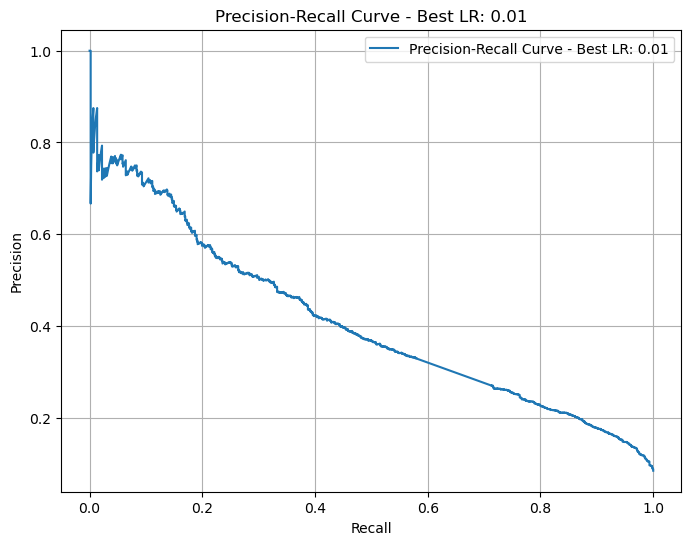

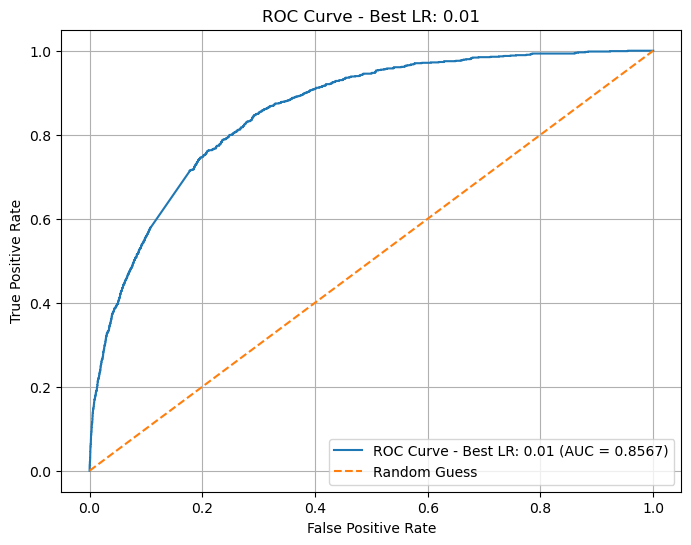

Test ROC AUC Score: 0.8567

=== Final Results ===
Best Learning Rate: 0.01
Test Loss: 0.2163
Test Accuracy: 0.7548
Test ROC AUC: 0.8567


In [68]:
# Run with multiple learning rates and test the best model
learning_rates = [0.01,0.001,0.0001]
modelX=NeuralNet(X_train_tensor.shape[1])
best_lr, test_loss, test_accuracy, roc_auc, best_model = train_eval_find_best_lr_test(
    modelX,
    X_train_tensor, Y_train_tensor,
    X_val_tensor, Y_val_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search and Testing"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

In [69]:

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")


=== Final Results ===
Best Learning Rate: 0.01
Test Loss: 0.2163
Test Accuracy: 0.7548
Test ROC AUC: 0.8567



=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 659/659 [00:00<00:00, 736.90batch/s, loss=0.31]  


Epoch 1/50: Train Loss = 0.2271, Val Loss = 0.2142, Val Accuracy = 0.9245


Epoch 1: 100%|██████████| 659/659 [00:00<00:00, 726.30batch/s, loss=0.297] 


Epoch 2/50: Train Loss = 0.2133, Val Loss = 0.2127, Val Accuracy = 0.9263


Epoch 2: 100%|██████████| 659/659 [00:00<00:00, 758.81batch/s, loss=0.274] 


Epoch 3/50: Train Loss = 0.2093, Val Loss = 0.2141, Val Accuracy = 0.9245


Epoch 3: 100%|██████████| 659/659 [00:00<00:00, 761.59batch/s, loss=0.256] 


Epoch 4/50: Train Loss = 0.2057, Val Loss = 0.2111, Val Accuracy = 0.9266


Epoch 4: 100%|██████████| 659/659 [00:00<00:00, 724.40batch/s, loss=0.201] 


Epoch 5/50: Train Loss = 0.2009, Val Loss = 0.2088, Val Accuracy = 0.9255


Epoch 5: 100%|██████████| 659/659 [00:00<00:00, 676.05batch/s, loss=0.157] 


Epoch 6/50: Train Loss = 0.1976, Val Loss = 0.2097, Val Accuracy = 0.9260


Epoch 6: 100%|██████████| 659/659 [00:00<00:00, 732.90batch/s, loss=0.173] 


Epoch 7/50: Train Loss = 0.1955, Val Loss = 0.2110, Val Accuracy = 0.9254


Epoch 7: 100%|██████████| 659/659 [00:00<00:00, 725.76batch/s, loss=0.15]  


Epoch 8/50: Train Loss = 0.1928, Val Loss = 0.2123, Val Accuracy = 0.9241


Epoch 8: 100%|██████████| 659/659 [00:00<00:00, 804.89batch/s, loss=0.162] 


Epoch 9/50: Train Loss = 0.1897, Val Loss = 0.2128, Val Accuracy = 0.9237


Epoch 9: 100%|██████████| 659/659 [00:00<00:00, 813.69batch/s, loss=0.144] 


Epoch 10/50: Train Loss = 0.1883, Val Loss = 0.2156, Val Accuracy = 0.9210


Epoch 10: 100%|██████████| 659/659 [00:00<00:00, 806.47batch/s, loss=0.15]  


Epoch 11/50: Train Loss = 0.1856, Val Loss = 0.2155, Val Accuracy = 0.9229


Epoch 11: 100%|██████████| 659/659 [00:00<00:00, 813.28batch/s, loss=0.15]  


Epoch 12/50: Train Loss = 0.1816, Val Loss = 0.2172, Val Accuracy = 0.9217


Epoch 12: 100%|██████████| 659/659 [00:00<00:00, 792.99batch/s, loss=0.15]  


Epoch 13/50: Train Loss = 0.1775, Val Loss = 0.2238, Val Accuracy = 0.9221


Epoch 13: 100%|██████████| 659/659 [00:00<00:00, 766.88batch/s, loss=0.157] 


Epoch 14/50: Train Loss = 0.1759, Val Loss = 0.2289, Val Accuracy = 0.9186


Epoch 14: 100%|██████████| 659/659 [00:00<00:00, 794.34batch/s, loss=0.164] 


Epoch 15/50: Train Loss = 0.1743, Val Loss = 0.2297, Val Accuracy = 0.9215


Epoch 15: 100%|██████████| 659/659 [00:00<00:00, 810.47batch/s, loss=0.204] 


Epoch 16/50: Train Loss = 0.1685, Val Loss = 0.2307, Val Accuracy = 0.9196


Epoch 16: 100%|██████████| 659/659 [00:00<00:00, 813.06batch/s, loss=0.167] 


Epoch 17/50: Train Loss = 0.1695, Val Loss = 0.2359, Val Accuracy = 0.9198


Epoch 17: 100%|██████████| 659/659 [00:00<00:00, 789.20batch/s, loss=0.163] 


Epoch 18/50: Train Loss = 0.1647, Val Loss = 0.2387, Val Accuracy = 0.9219


Epoch 18: 100%|██████████| 659/659 [00:00<00:00, 746.80batch/s, loss=0.186] 


Epoch 19/50: Train Loss = 0.1612, Val Loss = 0.2363, Val Accuracy = 0.9194


Epoch 19: 100%|██████████| 659/659 [00:00<00:00, 662.32batch/s, loss=0.172] 


Epoch 20/50: Train Loss = 0.1591, Val Loss = 0.2335, Val Accuracy = 0.9197


Epoch 20: 100%|██████████| 659/659 [00:00<00:00, 719.31batch/s, loss=0.173] 


Epoch 21/50: Train Loss = 0.1577, Val Loss = 0.2489, Val Accuracy = 0.9201


Epoch 21: 100%|██████████| 659/659 [00:00<00:00, 706.91batch/s, loss=0.169] 


Epoch 22/50: Train Loss = 0.1572, Val Loss = 0.2520, Val Accuracy = 0.9174


Epoch 22: 100%|██████████| 659/659 [00:00<00:00, 697.99batch/s, loss=0.139] 


Epoch 23/50: Train Loss = 0.1529, Val Loss = 0.2542, Val Accuracy = 0.9192


Epoch 23: 100%|██████████| 659/659 [00:00<00:00, 708.44batch/s, loss=0.146] 


Epoch 24/50: Train Loss = 0.1543, Val Loss = 0.2565, Val Accuracy = 0.9186


Epoch 24: 100%|██████████| 659/659 [00:00<00:00, 691.64batch/s, loss=0.14]  


Epoch 25/50: Train Loss = 0.1512, Val Loss = 0.2820, Val Accuracy = 0.9163


Epoch 25: 100%|██████████| 659/659 [00:00<00:00, 660.06batch/s, loss=0.14]  


Epoch 26/50: Train Loss = 0.1481, Val Loss = 0.2480, Val Accuracy = 0.9193


Epoch 26: 100%|██████████| 659/659 [00:00<00:00, 755.13batch/s, loss=0.147] 


Epoch 27/50: Train Loss = 0.1482, Val Loss = 0.2625, Val Accuracy = 0.9189


Epoch 27: 100%|██████████| 659/659 [00:00<00:00, 679.77batch/s, loss=0.143] 


Epoch 28/50: Train Loss = 0.1487, Val Loss = 0.2569, Val Accuracy = 0.9212


Epoch 28: 100%|██████████| 659/659 [00:01<00:00, 628.08batch/s, loss=0.133] 


Epoch 29/50: Train Loss = 0.1443, Val Loss = 0.2794, Val Accuracy = 0.9189


Epoch 29: 100%|██████████| 659/659 [00:00<00:00, 666.05batch/s, loss=0.146] 


Epoch 30/50: Train Loss = 0.1438, Val Loss = 0.2848, Val Accuracy = 0.9192


Epoch 30: 100%|██████████| 659/659 [00:00<00:00, 774.30batch/s, loss=0.148] 


Epoch 31/50: Train Loss = 0.1435, Val Loss = 0.2841, Val Accuracy = 0.9178


Epoch 31: 100%|██████████| 659/659 [00:00<00:00, 736.10batch/s, loss=0.133] 


Epoch 32/50: Train Loss = 0.1419, Val Loss = 0.2914, Val Accuracy = 0.9166


Epoch 32: 100%|██████████| 659/659 [00:00<00:00, 798.09batch/s, loss=0.144] 


Epoch 33/50: Train Loss = 0.1424, Val Loss = 0.2942, Val Accuracy = 0.9170


Epoch 33: 100%|██████████| 659/659 [00:00<00:00, 799.15batch/s, loss=0.138] 


Epoch 34/50: Train Loss = 0.1378, Val Loss = 0.3211, Val Accuracy = 0.9161


Epoch 34: 100%|██████████| 659/659 [00:00<00:00, 792.68batch/s, loss=0.136] 


Epoch 35/50: Train Loss = 0.1383, Val Loss = 0.3121, Val Accuracy = 0.9188


Epoch 35: 100%|██████████| 659/659 [00:00<00:00, 818.01batch/s, loss=0.13]  


Epoch 36/50: Train Loss = 0.1392, Val Loss = 0.3642, Val Accuracy = 0.9165


Epoch 36: 100%|██████████| 659/659 [00:00<00:00, 836.64batch/s, loss=0.119] 


Epoch 37/50: Train Loss = 0.1366, Val Loss = 0.3516, Val Accuracy = 0.9139


Epoch 37: 100%|██████████| 659/659 [00:00<00:00, 798.62batch/s, loss=0.128] 


Epoch 38/50: Train Loss = 0.1335, Val Loss = 0.3814, Val Accuracy = 0.9166


Epoch 38: 100%|██████████| 659/659 [00:00<00:00, 838.59batch/s, loss=0.123] 


Epoch 39/50: Train Loss = 0.1337, Val Loss = 0.4817, Val Accuracy = 0.9145


Epoch 39: 100%|██████████| 659/659 [00:00<00:00, 837.51batch/s, loss=0.13]  


Epoch 40/50: Train Loss = 0.1321, Val Loss = 0.4137, Val Accuracy = 0.9149


Epoch 40: 100%|██████████| 659/659 [00:00<00:00, 803.49batch/s, loss=0.13]  


Epoch 41/50: Train Loss = 0.1330, Val Loss = 0.3794, Val Accuracy = 0.9146


Epoch 41: 100%|██████████| 659/659 [00:00<00:00, 842.81batch/s, loss=0.136] 


Epoch 42/50: Train Loss = 0.1302, Val Loss = 0.3513, Val Accuracy = 0.9159


Epoch 42: 100%|██████████| 659/659 [00:00<00:00, 847.85batch/s, loss=0.124] 


Epoch 43/50: Train Loss = 0.1273, Val Loss = 0.3223, Val Accuracy = 0.9182


Epoch 43: 100%|██████████| 659/659 [00:00<00:00, 808.11batch/s, loss=0.128] 


Epoch 44/50: Train Loss = 0.1277, Val Loss = 0.4326, Val Accuracy = 0.9171


Epoch 44: 100%|██████████| 659/659 [00:00<00:00, 847.72batch/s, loss=0.122] 


Epoch 45/50: Train Loss = 0.1315, Val Loss = 0.4532, Val Accuracy = 0.9135


Epoch 45: 100%|██████████| 659/659 [00:00<00:00, 846.44batch/s, loss=0.135] 


Epoch 46/50: Train Loss = 0.1249, Val Loss = 0.3937, Val Accuracy = 0.9149


Epoch 46: 100%|██████████| 659/659 [00:00<00:00, 802.44batch/s, loss=0.133] 


Epoch 47/50: Train Loss = 0.1253, Val Loss = 0.5760, Val Accuracy = 0.9165


Epoch 47: 100%|██████████| 659/659 [00:00<00:00, 847.59batch/s, loss=0.129] 


Epoch 48/50: Train Loss = 0.1262, Val Loss = 0.3830, Val Accuracy = 0.9185


Epoch 48: 100%|██████████| 659/659 [00:00<00:00, 851.65batch/s, loss=0.118] 


Epoch 49/50: Train Loss = 0.1211, Val Loss = 0.4327, Val Accuracy = 0.9169


Epoch 49: 100%|██████████| 659/659 [00:00<00:00, 807.35batch/s, loss=0.125] 


Epoch 50/50: Train Loss = 0.1201, Val Loss = 0.4579, Val Accuracy = 0.9177
Best Validation Loss: 0.2088

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 659/659 [00:00<00:00, 746.82batch/s, loss=0.114] 


Epoch 1/50: Train Loss = 0.1099, Val Loss = 0.6272, Val Accuracy = 0.9151


Epoch 1: 100%|██████████| 659/659 [00:00<00:00, 764.50batch/s, loss=0.104] 


Epoch 2/50: Train Loss = 0.1009, Val Loss = 0.7634, Val Accuracy = 0.9153


Epoch 2: 100%|██████████| 659/659 [00:00<00:00, 840.61batch/s, loss=0.0982]


Epoch 3/50: Train Loss = 0.0966, Val Loss = 0.8302, Val Accuracy = 0.9154


Epoch 3: 100%|██████████| 659/659 [00:00<00:00, 837.93batch/s, loss=0.0955]


Epoch 4/50: Train Loss = 0.0933, Val Loss = 0.9762, Val Accuracy = 0.9146


Epoch 4: 100%|██████████| 659/659 [00:00<00:00, 811.42batch/s, loss=0.0934] 


Epoch 5/50: Train Loss = 0.0913, Val Loss = 1.0908, Val Accuracy = 0.9155


Epoch 5: 100%|██████████| 659/659 [00:00<00:00, 860.90batch/s, loss=0.093]  


Epoch 6/50: Train Loss = 0.0889, Val Loss = 1.1753, Val Accuracy = 0.9138


Epoch 6: 100%|██████████| 659/659 [00:00<00:00, 852.17batch/s, loss=0.0916] 


Epoch 7/50: Train Loss = 0.0884, Val Loss = 1.2094, Val Accuracy = 0.9130


Epoch 7: 100%|██████████| 659/659 [00:00<00:00, 843.40batch/s, loss=0.0906] 


Epoch 8/50: Train Loss = 0.0861, Val Loss = 1.3748, Val Accuracy = 0.9143


Epoch 8: 100%|██████████| 659/659 [00:00<00:00, 745.26batch/s, loss=0.089]  


Epoch 9/50: Train Loss = 0.0856, Val Loss = 1.3889, Val Accuracy = 0.9138


Epoch 9: 100%|██████████| 659/659 [00:00<00:00, 758.10batch/s, loss=0.0873] 


Epoch 10/50: Train Loss = 0.0841, Val Loss = 1.5372, Val Accuracy = 0.9145


Epoch 10: 100%|██████████| 659/659 [00:00<00:00, 666.26batch/s, loss=0.102]  


Epoch 11/50: Train Loss = 0.0834, Val Loss = 1.6673, Val Accuracy = 0.9139


Epoch 11: 100%|██████████| 659/659 [00:00<00:00, 773.67batch/s, loss=0.0858] 


Epoch 12/50: Train Loss = 0.0821, Val Loss = 1.8316, Val Accuracy = 0.9132


Epoch 12: 100%|██████████| 659/659 [00:01<00:00, 655.47batch/s, loss=0.0828] 


Epoch 13/50: Train Loss = 0.0825, Val Loss = 1.7873, Val Accuracy = 0.9132


Epoch 13: 100%|██████████| 659/659 [00:00<00:00, 710.06batch/s, loss=0.0823] 


Epoch 14/50: Train Loss = 0.0808, Val Loss = 1.7655, Val Accuracy = 0.9126


Epoch 14: 100%|██████████| 659/659 [00:00<00:00, 711.30batch/s, loss=0.0826] 


Epoch 15/50: Train Loss = 0.0803, Val Loss = 1.8756, Val Accuracy = 0.9130


Epoch 15: 100%|██████████| 659/659 [00:00<00:00, 710.61batch/s, loss=0.0814] 


Epoch 16/50: Train Loss = 0.0794, Val Loss = 1.9259, Val Accuracy = 0.9130


Epoch 16: 100%|██████████| 659/659 [00:00<00:00, 672.60batch/s, loss=0.0799] 


Epoch 17/50: Train Loss = 0.0792, Val Loss = 1.9860, Val Accuracy = 0.9131


Epoch 17: 100%|██████████| 659/659 [00:00<00:00, 748.53batch/s, loss=0.0822] 


Epoch 18/50: Train Loss = 0.0787, Val Loss = 1.9106, Val Accuracy = 0.9139


Epoch 18: 100%|██████████| 659/659 [00:00<00:00, 670.21batch/s, loss=0.0788] 


Epoch 19/50: Train Loss = 0.0782, Val Loss = 1.9581, Val Accuracy = 0.9128


Epoch 19: 100%|██████████| 659/659 [00:00<00:00, 666.04batch/s, loss=0.0786] 


Epoch 20/50: Train Loss = 0.0773, Val Loss = 2.0505, Val Accuracy = 0.9126


Epoch 20: 100%|██████████| 659/659 [00:00<00:00, 676.69batch/s, loss=0.0769] 


Epoch 21/50: Train Loss = 0.0757, Val Loss = 2.0053, Val Accuracy = 0.9142


Epoch 21: 100%|██████████| 659/659 [00:00<00:00, 663.84batch/s, loss=0.0761] 


Epoch 22/50: Train Loss = 0.0757, Val Loss = 2.0882, Val Accuracy = 0.9135


Epoch 22: 100%|██████████| 659/659 [00:01<00:00, 614.39batch/s, loss=0.0772] 


Epoch 23/50: Train Loss = 0.0752, Val Loss = 2.1666, Val Accuracy = 0.9145


Epoch 23: 100%|██████████| 659/659 [00:01<00:00, 563.59batch/s, loss=0.0753] 


Epoch 24/50: Train Loss = 0.0750, Val Loss = 2.1341, Val Accuracy = 0.9137


Epoch 24: 100%|██████████| 659/659 [00:01<00:00, 618.65batch/s, loss=0.0744] 


Epoch 25/50: Train Loss = 0.0743, Val Loss = 2.1134, Val Accuracy = 0.9139


Epoch 25: 100%|██████████| 659/659 [00:00<00:00, 744.28batch/s, loss=0.0699] 


Epoch 26/50: Train Loss = 0.0739, Val Loss = 2.2053, Val Accuracy = 0.9128


Epoch 26: 100%|██████████| 659/659 [00:00<00:00, 748.89batch/s, loss=0.0705] 


Epoch 27/50: Train Loss = 0.0730, Val Loss = 2.2184, Val Accuracy = 0.9130


Epoch 27: 100%|██████████| 659/659 [00:00<00:00, 754.99batch/s, loss=0.0655] 


Epoch 28/50: Train Loss = 0.0728, Val Loss = 2.2168, Val Accuracy = 0.9122


Epoch 28: 100%|██████████| 659/659 [00:00<00:00, 751.39batch/s, loss=0.0656] 


Epoch 29/50: Train Loss = 0.0723, Val Loss = 2.1945, Val Accuracy = 0.9126


Epoch 29: 100%|██████████| 659/659 [00:00<00:00, 715.84batch/s, loss=0.0592] 


Epoch 30/50: Train Loss = 0.0718, Val Loss = 2.2352, Val Accuracy = 0.9123


Epoch 30: 100%|██████████| 659/659 [00:00<00:00, 733.60batch/s, loss=0.0613] 


Epoch 31/50: Train Loss = 0.0719, Val Loss = 2.1777, Val Accuracy = 0.9122


Epoch 31: 100%|██████████| 659/659 [00:00<00:00, 725.70batch/s, loss=0.059]  


Epoch 32/50: Train Loss = 0.0707, Val Loss = 2.3104, Val Accuracy = 0.9122


Epoch 32: 100%|██████████| 659/659 [00:00<00:00, 734.41batch/s, loss=0.0607] 


Epoch 33/50: Train Loss = 0.0706, Val Loss = 2.2300, Val Accuracy = 0.9150


Epoch 33: 100%|██████████| 659/659 [00:00<00:00, 698.42batch/s, loss=0.0571] 


Epoch 34/50: Train Loss = 0.0702, Val Loss = 2.3026, Val Accuracy = 0.9130


Epoch 34: 100%|██████████| 659/659 [00:00<00:00, 751.88batch/s, loss=0.057]  


Epoch 35/50: Train Loss = 0.0699, Val Loss = 2.4432, Val Accuracy = 0.9126


Epoch 35: 100%|██████████| 659/659 [00:00<00:00, 748.19batch/s, loss=0.0553] 


Epoch 36/50: Train Loss = 0.0697, Val Loss = 2.2761, Val Accuracy = 0.9138


Epoch 36: 100%|██████████| 659/659 [00:00<00:00, 734.52batch/s, loss=0.0556] 


Epoch 37/50: Train Loss = 0.0690, Val Loss = 2.3169, Val Accuracy = 0.9139


Epoch 37: 100%|██████████| 659/659 [00:00<00:00, 701.24batch/s, loss=0.0548] 


Epoch 38/50: Train Loss = 0.0685, Val Loss = 2.4176, Val Accuracy = 0.9124


Epoch 38: 100%|██████████| 659/659 [00:00<00:00, 693.97batch/s, loss=0.056]  


Epoch 39/50: Train Loss = 0.0679, Val Loss = 2.4651, Val Accuracy = 0.9126


Epoch 39: 100%|██████████| 659/659 [00:00<00:00, 750.30batch/s, loss=0.0576] 


Epoch 40/50: Train Loss = 0.0679, Val Loss = 2.5692, Val Accuracy = 0.9114


Epoch 40: 100%|██████████| 659/659 [00:00<00:00, 727.83batch/s, loss=0.053]  


Epoch 41/50: Train Loss = 0.0670, Val Loss = 2.6254, Val Accuracy = 0.9122


Epoch 41: 100%|██████████| 659/659 [00:00<00:00, 711.19batch/s, loss=0.0521] 


Epoch 42/50: Train Loss = 0.0669, Val Loss = 2.5656, Val Accuracy = 0.9132


Epoch 42: 100%|██████████| 659/659 [00:00<00:00, 787.85batch/s, loss=0.0532] 


Epoch 43/50: Train Loss = 0.0674, Val Loss = 2.5720, Val Accuracy = 0.9130


Epoch 43: 100%|██████████| 659/659 [00:00<00:00, 820.67batch/s, loss=0.052]  


Epoch 44/50: Train Loss = 0.0674, Val Loss = 2.5628, Val Accuracy = 0.9123


Epoch 44: 100%|██████████| 659/659 [00:00<00:00, 774.11batch/s, loss=0.0514] 


Epoch 45/50: Train Loss = 0.0664, Val Loss = 2.5792, Val Accuracy = 0.9127


Epoch 45: 100%|██████████| 659/659 [00:00<00:00, 779.42batch/s, loss=0.051]  


Epoch 46/50: Train Loss = 0.0658, Val Loss = 2.5682, Val Accuracy = 0.9130


Epoch 46: 100%|██████████| 659/659 [00:00<00:00, 710.98batch/s, loss=0.0508] 


Epoch 47/50: Train Loss = 0.0654, Val Loss = 2.5523, Val Accuracy = 0.9132


Epoch 47: 100%|██████████| 659/659 [00:00<00:00, 721.10batch/s, loss=0.0507] 


Epoch 48/50: Train Loss = 0.0651, Val Loss = 2.6401, Val Accuracy = 0.9122


Epoch 48: 100%|██████████| 659/659 [00:00<00:00, 829.39batch/s, loss=0.0495] 


Epoch 49/50: Train Loss = 0.0652, Val Loss = 2.7133, Val Accuracy = 0.9120


Epoch 49: 100%|██████████| 659/659 [00:00<00:00, 831.06batch/s, loss=0.0513] 


Epoch 50/50: Train Loss = 0.0651, Val Loss = 2.6420, Val Accuracy = 0.9127
Best Validation Loss: 0.6272

=== Running with Learning Rate: 0.0001 ===


Epoch 0: 100%|██████████| 659/659 [00:00<00:00, 744.04batch/s, loss=0.0501]  


Epoch 1/50: Train Loss = 0.0631, Val Loss = 2.6360, Val Accuracy = 0.9135


Epoch 1: 100%|██████████| 659/659 [00:00<00:00, 813.10batch/s, loss=0.0495]  


Epoch 2/50: Train Loss = 0.0621, Val Loss = 2.6476, Val Accuracy = 0.9137


Epoch 2: 100%|██████████| 659/659 [00:00<00:00, 777.75batch/s, loss=0.0492] 


Epoch 3/50: Train Loss = 0.0614, Val Loss = 2.6873, Val Accuracy = 0.9138


Epoch 3: 100%|██████████| 659/659 [00:00<00:00, 810.01batch/s, loss=0.0487]  


Epoch 4/50: Train Loss = 0.0612, Val Loss = 2.6939, Val Accuracy = 0.8885


Epoch 4: 100%|██████████| 659/659 [00:00<00:00, 822.06batch/s, loss=0.0483]  


Epoch 5/50: Train Loss = 0.0611, Val Loss = 2.7038, Val Accuracy = 0.8888


Epoch 5: 100%|██████████| 659/659 [00:00<00:00, 779.63batch/s, loss=0.0479]  


Epoch 6/50: Train Loss = 0.0608, Val Loss = 2.7371, Val Accuracy = 0.8893


Epoch 6: 100%|██████████| 659/659 [00:00<00:00, 815.40batch/s, loss=0.0475]  


Epoch 7/50: Train Loss = 0.0607, Val Loss = 2.7708, Val Accuracy = 0.8898


Epoch 7: 100%|██████████| 659/659 [00:00<00:00, 807.56batch/s, loss=0.0473]  


Epoch 8/50: Train Loss = 0.0605, Val Loss = 2.8010, Val Accuracy = 0.8898


Epoch 8: 100%|██████████| 659/659 [00:00<00:00, 803.60batch/s, loss=0.0471]  


Epoch 9/50: Train Loss = 0.0604, Val Loss = 2.8234, Val Accuracy = 0.8897


Epoch 9: 100%|██████████| 659/659 [00:00<00:00, 849.52batch/s, loss=0.047]   


Epoch 10/50: Train Loss = 0.0603, Val Loss = 2.8447, Val Accuracy = 0.8892


Epoch 10: 100%|██████████| 659/659 [00:00<00:00, 851.84batch/s, loss=0.0467]  


Epoch 11/50: Train Loss = 0.0603, Val Loss = 2.8485, Val Accuracy = 0.8904


Epoch 11: 100%|██████████| 659/659 [00:00<00:00, 800.02batch/s, loss=0.0467]  


Epoch 12/50: Train Loss = 0.0602, Val Loss = 2.8817, Val Accuracy = 0.8901


Epoch 12: 100%|██████████| 659/659 [00:00<00:00, 722.61batch/s, loss=0.0465]  


Epoch 13/50: Train Loss = 0.0601, Val Loss = 2.9157, Val Accuracy = 0.8905


Epoch 13: 100%|██████████| 659/659 [00:00<00:00, 708.10batch/s, loss=0.0463]  


Epoch 14/50: Train Loss = 0.0599, Val Loss = 2.8886, Val Accuracy = 0.8898


Epoch 14: 100%|██████████| 659/659 [00:00<00:00, 800.82batch/s, loss=0.046]   


Epoch 15/50: Train Loss = 0.0597, Val Loss = 2.9276, Val Accuracy = 0.8905


Epoch 15: 100%|██████████| 659/659 [00:00<00:00, 779.13batch/s, loss=0.0459]  


Epoch 16/50: Train Loss = 0.0596, Val Loss = 2.9390, Val Accuracy = 0.8902


Epoch 16: 100%|██████████| 659/659 [00:00<00:00, 783.11batch/s, loss=0.0458]  


Epoch 17/50: Train Loss = 0.0595, Val Loss = 2.9943, Val Accuracy = 0.8900


Epoch 17: 100%|██████████| 659/659 [00:00<00:00, 714.15batch/s, loss=0.0458] 


Epoch 18/50: Train Loss = 0.0595, Val Loss = 3.0049, Val Accuracy = 0.8896


Epoch 18: 100%|██████████| 659/659 [00:00<00:00, 759.76batch/s, loss=0.0453]  


Epoch 19/50: Train Loss = 0.0595, Val Loss = 3.0067, Val Accuracy = 0.8905


Epoch 19: 100%|██████████| 659/659 [00:00<00:00, 659.86batch/s, loss=0.0452]  


Epoch 20/50: Train Loss = 0.0593, Val Loss = 3.0477, Val Accuracy = 0.8902


Epoch 20: 100%|██████████| 659/659 [00:00<00:00, 672.16batch/s, loss=0.0452]  


Epoch 21/50: Train Loss = 0.0592, Val Loss = 3.0514, Val Accuracy = 0.8905


Epoch 21: 100%|██████████| 659/659 [00:00<00:00, 676.28batch/s, loss=0.0451]  


Epoch 22/50: Train Loss = 0.0591, Val Loss = 3.0370, Val Accuracy = 0.8911


Epoch 22: 100%|██████████| 659/659 [00:00<00:00, 678.25batch/s, loss=0.0451]  


Epoch 23/50: Train Loss = 0.0591, Val Loss = 3.0651, Val Accuracy = 0.8909


Epoch 23: 100%|██████████| 659/659 [00:00<00:00, 665.17batch/s, loss=0.045]   


Epoch 24/50: Train Loss = 0.0590, Val Loss = 3.0883, Val Accuracy = 0.8907


Epoch 24: 100%|██████████| 659/659 [00:00<00:00, 729.37batch/s, loss=0.0448]  


Epoch 25/50: Train Loss = 0.0589, Val Loss = 3.1095, Val Accuracy = 0.8908


Epoch 25: 100%|██████████| 659/659 [00:00<00:00, 714.83batch/s, loss=0.0448]  


Epoch 26/50: Train Loss = 0.0588, Val Loss = 3.1001, Val Accuracy = 0.8907


Epoch 26: 100%|██████████| 659/659 [00:00<00:00, 699.69batch/s, loss=0.0448]  


Epoch 27/50: Train Loss = 0.0587, Val Loss = 3.1369, Val Accuracy = 0.8904


Epoch 27: 100%|██████████| 659/659 [00:00<00:00, 718.31batch/s, loss=0.0446]  


Epoch 28/50: Train Loss = 0.0586, Val Loss = 3.1506, Val Accuracy = 0.8904


Epoch 28: 100%|██████████| 659/659 [00:00<00:00, 727.67batch/s, loss=0.0446]  


Epoch 29/50: Train Loss = 0.0586, Val Loss = 3.1582, Val Accuracy = 0.8912


Epoch 29: 100%|██████████| 659/659 [00:00<00:00, 703.33batch/s, loss=0.0443]  


Epoch 30/50: Train Loss = 0.0585, Val Loss = 3.1677, Val Accuracy = 0.8907


Epoch 30: 100%|██████████| 659/659 [00:00<00:00, 717.43batch/s, loss=0.0444]  


Epoch 31/50: Train Loss = 0.0584, Val Loss = 3.1726, Val Accuracy = 0.8909


Epoch 31: 100%|██████████| 659/659 [00:00<00:00, 737.30batch/s, loss=0.0443]  


Epoch 32/50: Train Loss = 0.0583, Val Loss = 3.1944, Val Accuracy = 0.8911


Epoch 32: 100%|██████████| 659/659 [00:00<00:00, 720.52batch/s, loss=0.044]   


Epoch 33/50: Train Loss = 0.0583, Val Loss = 3.2386, Val Accuracy = 0.8913


Epoch 33: 100%|██████████| 659/659 [00:00<00:00, 727.76batch/s, loss=0.0443] 


Epoch 34/50: Train Loss = 0.0582, Val Loss = 3.2614, Val Accuracy = 0.8908


Epoch 34: 100%|██████████| 659/659 [00:01<00:00, 602.99batch/s, loss=0.0442]  


Epoch 35/50: Train Loss = 0.0581, Val Loss = 3.2567, Val Accuracy = 0.8909


Epoch 35: 100%|██████████| 659/659 [00:00<00:00, 727.24batch/s, loss=0.0441]  


Epoch 36/50: Train Loss = 0.0580, Val Loss = 3.2787, Val Accuracy = 0.8907


Epoch 36: 100%|██████████| 659/659 [00:00<00:00, 661.93batch/s, loss=0.044]   


Epoch 37/50: Train Loss = 0.0579, Val Loss = 3.2894, Val Accuracy = 0.8904


Epoch 37: 100%|██████████| 659/659 [00:00<00:00, 699.52batch/s, loss=0.0439]  


Epoch 38/50: Train Loss = 0.0579, Val Loss = 3.3160, Val Accuracy = 0.8909


Epoch 38: 100%|██████████| 659/659 [00:01<00:00, 646.35batch/s, loss=0.0439]  


Epoch 39/50: Train Loss = 0.0579, Val Loss = 3.3215, Val Accuracy = 0.8900


Epoch 39: 100%|██████████| 659/659 [00:01<00:00, 652.09batch/s, loss=0.0439]  


Epoch 40/50: Train Loss = 0.0577, Val Loss = 3.3464, Val Accuracy = 0.8901


Epoch 40: 100%|██████████| 659/659 [00:00<00:00, 731.25batch/s, loss=0.0438]  


Epoch 41/50: Train Loss = 0.0576, Val Loss = 3.3271, Val Accuracy = 0.8898


Epoch 41: 100%|██████████| 659/659 [00:00<00:00, 718.90batch/s, loss=0.0436]  


Epoch 42/50: Train Loss = 0.0576, Val Loss = 3.3538, Val Accuracy = 0.8900


Epoch 42: 100%|██████████| 659/659 [00:00<00:00, 744.62batch/s, loss=0.0434]  


Epoch 43/50: Train Loss = 0.0575, Val Loss = 3.3508, Val Accuracy = 0.8897


Epoch 43: 100%|██████████| 659/659 [00:00<00:00, 736.12batch/s, loss=0.0433]  


Epoch 44/50: Train Loss = 0.0574, Val Loss = 3.3976, Val Accuracy = 0.8898


Epoch 44: 100%|██████████| 659/659 [00:00<00:00, 753.21batch/s, loss=0.0433]  


Epoch 45/50: Train Loss = 0.0574, Val Loss = 3.4026, Val Accuracy = 0.8893


Epoch 45: 100%|██████████| 659/659 [00:00<00:00, 743.41batch/s, loss=0.0432]  


Epoch 46/50: Train Loss = 0.0573, Val Loss = 3.4130, Val Accuracy = 0.8892


Epoch 46: 100%|██████████| 659/659 [00:00<00:00, 731.29batch/s, loss=0.0431]  


Epoch 47/50: Train Loss = 0.0573, Val Loss = 3.4301, Val Accuracy = 0.8894


Epoch 47: 100%|██████████| 659/659 [00:00<00:00, 711.13batch/s, loss=0.0431]  


Epoch 48/50: Train Loss = 0.0572, Val Loss = 3.4663, Val Accuracy = 0.8897


Epoch 48: 100%|██████████| 659/659 [00:00<00:00, 707.87batch/s, loss=0.0429]  


Epoch 49/50: Train Loss = 0.0571, Val Loss = 3.4547, Val Accuracy = 0.8900


Epoch 49: 100%|██████████| 659/659 [00:00<00:00, 723.19batch/s, loss=0.043]   


Epoch 50/50: Train Loss = 0.0571, Val Loss = 3.4779, Val Accuracy = 0.8897
Best Validation Loss: 2.6360

=== Best Learning Rate: 0.01 ===
Best Validation Loss: 0.2088

Best Threshold: 0.10, Best TPR: 0.7222

=== Testing Model: Best LR: 0.01 ===
Test Loss: 0.2127, Test Accuracy: 0.8132

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     11348
         1.0       0.27      0.73      0.40      1043

    accuracy                           0.81     12391
   macro avg       0.62      0.78      0.64     12391
weighted avg       0.91      0.81      0.85     12391


Confusion Matrix:
[[9311 2037]
 [ 278  765]]


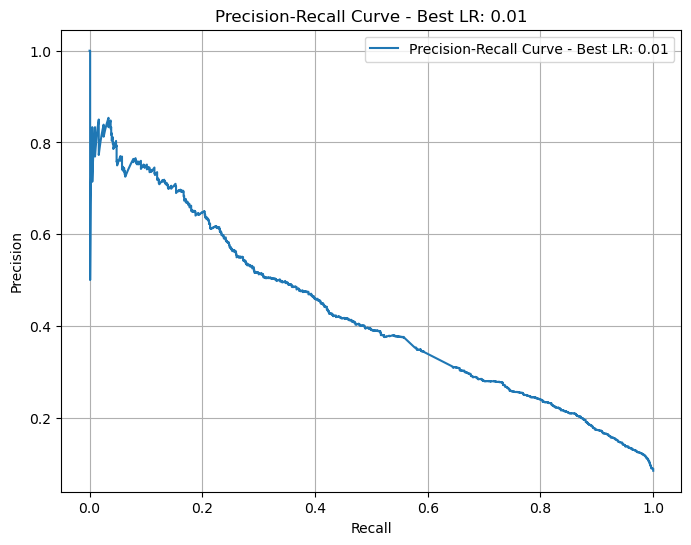

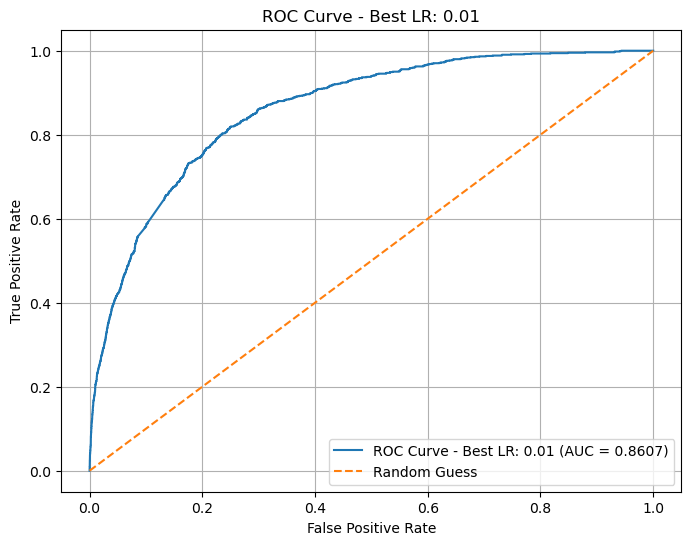

Test ROC AUC Score: 0.8607

=== Final Results ===
Best Learning Rate: 0.01
Test Loss: 0.2127
Test Accuracy: 0.8132
Test ROC AUC: 0.8607


In [70]:
# Run with multiple learning rates and test the best model
learning_rates = [0.01,0.001,0.0001]
modelY=BigModel(X_train_tensor.shape[1])
best_lr, test_loss, test_accuracy, roc_auc, best_model = train_eval_find_best_lr_test(
    modelY,
    X_train_tensor, Y_train_tensor,
    X_val_tensor, Y_val_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search and Testing"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")


=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 1206/1206 [00:01<00:00, 830.63batch/s, loss=0.45] 


Epoch 1/50: Train Loss = 0.4247, Val Loss = 0.3711, Val Accuracy = 0.8385


Epoch 1: 100%|██████████| 1206/1206 [00:01<00:00, 827.12batch/s, loss=0.518]


Epoch 2/50: Train Loss = 0.3960, Val Loss = 0.3558, Val Accuracy = 0.8454


Epoch 2: 100%|██████████| 1206/1206 [00:01<00:00, 831.53batch/s, loss=0.49] 


Epoch 3/50: Train Loss = 0.3779, Val Loss = 0.3401, Val Accuracy = 0.8558


Epoch 3: 100%|██████████| 1206/1206 [00:01<00:00, 832.30batch/s, loss=0.386]


Epoch 4/50: Train Loss = 0.3648, Val Loss = 0.3304, Val Accuracy = 0.8616


Epoch 4: 100%|██████████| 1206/1206 [00:01<00:00, 822.56batch/s, loss=0.384]


Epoch 5/50: Train Loss = 0.3537, Val Loss = 0.3237, Val Accuracy = 0.8632


Epoch 5: 100%|██████████| 1206/1206 [00:01<00:00, 836.21batch/s, loss=0.618]


Epoch 6/50: Train Loss = 0.3426, Val Loss = 0.3073, Val Accuracy = 0.8701


Epoch 6: 100%|██████████| 1206/1206 [00:01<00:00, 828.81batch/s, loss=0.386]


Epoch 7/50: Train Loss = 0.3306, Val Loss = 0.3011, Val Accuracy = 0.8758


Epoch 7: 100%|██████████| 1206/1206 [00:01<00:00, 821.39batch/s, loss=0.381]


Epoch 8/50: Train Loss = 0.3224, Val Loss = 0.2950, Val Accuracy = 0.8791


Epoch 8: 100%|██████████| 1206/1206 [00:01<00:00, 710.20batch/s, loss=0.44] 


Epoch 9/50: Train Loss = 0.3172, Val Loss = 0.2846, Val Accuracy = 0.8808


Epoch 9: 100%|██████████| 1206/1206 [00:01<00:00, 803.87batch/s, loss=0.304]


Epoch 10/50: Train Loss = 0.3120, Val Loss = 0.2832, Val Accuracy = 0.8787


Epoch 10: 100%|██████████| 1206/1206 [00:01<00:00, 815.03batch/s, loss=0.283]


Epoch 11/50: Train Loss = 0.3032, Val Loss = 0.2748, Val Accuracy = 0.8852


Epoch 11: 100%|██████████| 1206/1206 [00:01<00:00, 784.06batch/s, loss=0.302]


Epoch 12/50: Train Loss = 0.2997, Val Loss = 0.2692, Val Accuracy = 0.8874


Epoch 12: 100%|██████████| 1206/1206 [00:01<00:00, 833.28batch/s, loss=0.53] 


Epoch 13/50: Train Loss = 0.2944, Val Loss = 0.2687, Val Accuracy = 0.8881


Epoch 13: 100%|██████████| 1206/1206 [00:01<00:00, 786.70batch/s, loss=0.283]


Epoch 14/50: Train Loss = 0.2921, Val Loss = 0.2610, Val Accuracy = 0.8925


Epoch 14: 100%|██████████| 1206/1206 [00:01<00:00, 824.22batch/s, loss=0.366]


Epoch 15/50: Train Loss = 0.2897, Val Loss = 0.2599, Val Accuracy = 0.8911


Epoch 15: 100%|██████████| 1206/1206 [00:01<00:00, 782.57batch/s, loss=0.346]


Epoch 16/50: Train Loss = 0.2867, Val Loss = 0.2637, Val Accuracy = 0.8921


Epoch 16: 100%|██████████| 1206/1206 [00:01<00:00, 780.43batch/s, loss=0.408]


Epoch 17/50: Train Loss = 0.2834, Val Loss = 0.2614, Val Accuracy = 0.8893


Epoch 17: 100%|██████████| 1206/1206 [00:01<00:00, 770.23batch/s, loss=0.254]


Epoch 18/50: Train Loss = 0.2820, Val Loss = 0.2568, Val Accuracy = 0.8958


Epoch 18: 100%|██████████| 1206/1206 [00:01<00:00, 912.99batch/s, loss=0.367]


Epoch 19/50: Train Loss = 0.2782, Val Loss = 0.2536, Val Accuracy = 0.8979


Epoch 19: 100%|██████████| 1206/1206 [00:01<00:00, 859.06batch/s, loss=0.358]


Epoch 20/50: Train Loss = 0.2819, Val Loss = 0.2598, Val Accuracy = 0.8939


Epoch 20: 100%|██████████| 1206/1206 [00:01<00:00, 774.41batch/s, loss=0.299]


Epoch 21/50: Train Loss = 0.2770, Val Loss = 0.2517, Val Accuracy = 0.8963


Epoch 21: 100%|██████████| 1206/1206 [00:01<00:00, 882.98batch/s, loss=0.305] 


Epoch 22/50: Train Loss = 0.2744, Val Loss = 0.2536, Val Accuracy = 0.8970


Epoch 22: 100%|██████████| 1206/1206 [00:01<00:00, 880.90batch/s, loss=0.26] 


Epoch 23/50: Train Loss = 0.2729, Val Loss = 0.2500, Val Accuracy = 0.9001


Epoch 23: 100%|██████████| 1206/1206 [00:01<00:00, 947.79batch/s, loss=0.266]


Epoch 24/50: Train Loss = 0.2746, Val Loss = 0.2467, Val Accuracy = 0.8965


Epoch 24: 100%|██████████| 1206/1206 [00:01<00:00, 912.21batch/s, loss=0.246]


Epoch 25/50: Train Loss = 0.2716, Val Loss = 0.2566, Val Accuracy = 0.8928


Epoch 25: 100%|██████████| 1206/1206 [00:01<00:00, 928.89batch/s, loss=0.344] 


Epoch 26/50: Train Loss = 0.2711, Val Loss = 0.2503, Val Accuracy = 0.8946


Epoch 26: 100%|██████████| 1206/1206 [00:01<00:00, 935.61batch/s, loss=0.266]


Epoch 27/50: Train Loss = 0.2662, Val Loss = 0.2538, Val Accuracy = 0.8918


Epoch 27: 100%|██████████| 1206/1206 [00:01<00:00, 810.67batch/s, loss=0.328]


Epoch 28/50: Train Loss = 0.2654, Val Loss = 0.2369, Val Accuracy = 0.8981


Epoch 28: 100%|██████████| 1206/1206 [00:01<00:00, 821.76batch/s, loss=0.27] 


Epoch 29/50: Train Loss = 0.2667, Val Loss = 0.2494, Val Accuracy = 0.8995


Epoch 29: 100%|██████████| 1206/1206 [00:01<00:00, 918.07batch/s, loss=0.302]


Epoch 30/50: Train Loss = 0.2666, Val Loss = 0.2401, Val Accuracy = 0.9012


Epoch 30: 100%|██████████| 1206/1206 [00:01<00:00, 919.98batch/s, loss=0.232]


Epoch 31/50: Train Loss = 0.2647, Val Loss = 0.2484, Val Accuracy = 0.9006


Epoch 31: 100%|██████████| 1206/1206 [00:01<00:00, 945.54batch/s, loss=0.192] 


Epoch 32/50: Train Loss = 0.2609, Val Loss = 0.2412, Val Accuracy = 0.9000


Epoch 32: 100%|██████████| 1206/1206 [00:01<00:00, 914.68batch/s, loss=0.301]


Epoch 33/50: Train Loss = 0.2577, Val Loss = 0.2439, Val Accuracy = 0.9004


Epoch 33: 100%|██████████| 1206/1206 [00:01<00:00, 943.57batch/s, loss=0.245] 


Epoch 34/50: Train Loss = 0.2591, Val Loss = 0.2460, Val Accuracy = 0.8995


Epoch 34: 100%|██████████| 1206/1206 [00:01<00:00, 905.33batch/s, loss=0.177]


Epoch 35/50: Train Loss = 0.2564, Val Loss = 0.2374, Val Accuracy = 0.9034


Epoch 35: 100%|██████████| 1206/1206 [00:01<00:00, 916.20batch/s, loss=0.235]


Epoch 36/50: Train Loss = 0.2559, Val Loss = 0.2382, Val Accuracy = 0.9059


Epoch 36: 100%|██████████| 1206/1206 [00:01<00:00, 950.43batch/s, loss=0.263] 


Epoch 37/50: Train Loss = 0.2540, Val Loss = 0.2384, Val Accuracy = 0.9047


Epoch 37: 100%|██████████| 1206/1206 [00:01<00:00, 926.17batch/s, loss=0.396] 


Epoch 38/50: Train Loss = 0.2584, Val Loss = 0.2360, Val Accuracy = 0.9027


Epoch 38: 100%|██████████| 1206/1206 [00:01<00:00, 955.55batch/s, loss=0.224] 


Epoch 39/50: Train Loss = 0.2524, Val Loss = 0.2358, Val Accuracy = 0.9057


Epoch 39: 100%|██████████| 1206/1206 [00:01<00:00, 930.29batch/s, loss=0.147] 


Epoch 40/50: Train Loss = 0.2551, Val Loss = 0.2346, Val Accuracy = 0.9048


Epoch 40: 100%|██████████| 1206/1206 [00:01<00:00, 950.69batch/s, loss=0.186] 


Epoch 41/50: Train Loss = 0.2480, Val Loss = 0.2355, Val Accuracy = 0.9051


Epoch 41: 100%|██████████| 1206/1206 [00:01<00:00, 914.40batch/s, loss=0.288] 


Epoch 42/50: Train Loss = 0.2505, Val Loss = 0.2356, Val Accuracy = 0.9018


Epoch 42: 100%|██████████| 1206/1206 [00:01<00:00, 921.01batch/s, loss=0.176] 


Epoch 43/50: Train Loss = 0.2513, Val Loss = 0.2321, Val Accuracy = 0.9057


Epoch 43: 100%|██████████| 1206/1206 [00:01<00:00, 949.58batch/s, loss=0.427]


Epoch 44/50: Train Loss = 0.2520, Val Loss = 0.2328, Val Accuracy = 0.9089


Epoch 44: 100%|██████████| 1206/1206 [00:01<00:00, 923.46batch/s, loss=0.28]  


Epoch 45/50: Train Loss = 0.2469, Val Loss = 0.2276, Val Accuracy = 0.9100


Epoch 45: 100%|██████████| 1206/1206 [00:01<00:00, 928.39batch/s, loss=0.324]


Epoch 46/50: Train Loss = 0.2479, Val Loss = 0.2430, Val Accuracy = 0.9034


Epoch 46: 100%|██████████| 1206/1206 [00:01<00:00, 932.10batch/s, loss=0.232] 


Epoch 47/50: Train Loss = 0.2506, Val Loss = 0.2335, Val Accuracy = 0.9043


Epoch 47: 100%|██████████| 1206/1206 [00:01<00:00, 928.18batch/s, loss=0.198] 


Epoch 48/50: Train Loss = 0.2447, Val Loss = 0.2297, Val Accuracy = 0.9059


Epoch 48: 100%|██████████| 1206/1206 [00:01<00:00, 932.26batch/s, loss=0.205] 


Epoch 49/50: Train Loss = 0.2474, Val Loss = 0.2309, Val Accuracy = 0.9030


Epoch 49: 100%|██████████| 1206/1206 [00:01<00:00, 922.49batch/s, loss=0.304] 


Epoch 50/50: Train Loss = 0.2445, Val Loss = 0.2273, Val Accuracy = 0.9090
Best Validation Loss: 0.2273

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 1206/1206 [00:01<00:00, 950.13batch/s, loss=0.347] 


Epoch 1/50: Train Loss = 0.2147, Val Loss = 0.2120, Val Accuracy = 0.9172


Epoch 1: 100%|██████████| 1206/1206 [00:01<00:00, 877.11batch/s, loss=0.133] 


Epoch 2/50: Train Loss = 0.2030, Val Loss = 0.2064, Val Accuracy = 0.9204


Epoch 2: 100%|██████████| 1206/1206 [00:01<00:00, 822.71batch/s, loss=0.185] 


Epoch 3/50: Train Loss = 0.1967, Val Loss = 0.2031, Val Accuracy = 0.9209


Epoch 3: 100%|██████████| 1206/1206 [00:01<00:00, 916.14batch/s, loss=0.185] 


Epoch 4/50: Train Loss = 0.1964, Val Loss = 0.2039, Val Accuracy = 0.9208


Epoch 4: 100%|██████████| 1206/1206 [00:01<00:00, 924.75batch/s, loss=0.177] 


Epoch 5/50: Train Loss = 0.1903, Val Loss = 0.2010, Val Accuracy = 0.9229


Epoch 5: 100%|██████████| 1206/1206 [00:01<00:00, 944.02batch/s, loss=0.144] 


Epoch 6/50: Train Loss = 0.1880, Val Loss = 0.2003, Val Accuracy = 0.9230


Epoch 6: 100%|██████████| 1206/1206 [00:01<00:00, 877.95batch/s, loss=0.152] 


Epoch 7/50: Train Loss = 0.1872, Val Loss = 0.1994, Val Accuracy = 0.9235


Epoch 7: 100%|██████████| 1206/1206 [00:01<00:00, 908.40batch/s, loss=0.152] 


Epoch 8/50: Train Loss = 0.1831, Val Loss = 0.1976, Val Accuracy = 0.9253


Epoch 8: 100%|██████████| 1206/1206 [00:01<00:00, 943.63batch/s, loss=0.133] 


Epoch 9/50: Train Loss = 0.1824, Val Loss = 0.1982, Val Accuracy = 0.9240


Epoch 9: 100%|██████████| 1206/1206 [00:01<00:00, 926.37batch/s, loss=0.121] 


Epoch 10/50: Train Loss = 0.1832, Val Loss = 0.1977, Val Accuracy = 0.9247


Epoch 10: 100%|██████████| 1206/1206 [00:01<00:00, 920.79batch/s, loss=0.139] 


Epoch 11/50: Train Loss = 0.1831, Val Loss = 0.1968, Val Accuracy = 0.9240


Epoch 11: 100%|██████████| 1206/1206 [00:01<00:00, 945.25batch/s, loss=0.193] 


Epoch 12/50: Train Loss = 0.1789, Val Loss = 0.1952, Val Accuracy = 0.9249


Epoch 12: 100%|██████████| 1206/1206 [00:01<00:00, 919.93batch/s, loss=0.141] 


Epoch 13/50: Train Loss = 0.1809, Val Loss = 0.1953, Val Accuracy = 0.9240


Epoch 13: 100%|██████████| 1206/1206 [00:01<00:00, 950.26batch/s, loss=0.196] 


Epoch 14/50: Train Loss = 0.1787, Val Loss = 0.1947, Val Accuracy = 0.9239


Epoch 14: 100%|██████████| 1206/1206 [00:01<00:00, 919.69batch/s, loss=0.107] 


Epoch 15/50: Train Loss = 0.1784, Val Loss = 0.1937, Val Accuracy = 0.9244


Epoch 15: 100%|██████████| 1206/1206 [00:01<00:00, 946.13batch/s, loss=0.172] 


Epoch 16/50: Train Loss = 0.1787, Val Loss = 0.1916, Val Accuracy = 0.9244


Epoch 16: 100%|██████████| 1206/1206 [00:01<00:00, 919.88batch/s, loss=0.145] 


Epoch 17/50: Train Loss = 0.1771, Val Loss = 0.1950, Val Accuracy = 0.9252


Epoch 17: 100%|██████████| 1206/1206 [00:01<00:00, 929.13batch/s, loss=0.17]  


Epoch 18/50: Train Loss = 0.1771, Val Loss = 0.1932, Val Accuracy = 0.9257


Epoch 18: 100%|██████████| 1206/1206 [00:01<00:00, 955.10batch/s, loss=0.131] 


Epoch 19/50: Train Loss = 0.1770, Val Loss = 0.1932, Val Accuracy = 0.9257


Epoch 19: 100%|██████████| 1206/1206 [00:01<00:00, 912.76batch/s, loss=0.161] 


Epoch 20/50: Train Loss = 0.1744, Val Loss = 0.1909, Val Accuracy = 0.9254


Epoch 20: 100%|██████████| 1206/1206 [00:01<00:00, 941.17batch/s, loss=0.156] 


Epoch 21/50: Train Loss = 0.1743, Val Loss = 0.1904, Val Accuracy = 0.9274


Epoch 21: 100%|██████████| 1206/1206 [00:01<00:00, 917.15batch/s, loss=0.102] 


Epoch 22/50: Train Loss = 0.1730, Val Loss = 0.1917, Val Accuracy = 0.9277


Epoch 22: 100%|██████████| 1206/1206 [00:01<00:00, 940.22batch/s, loss=0.119] 


Epoch 23/50: Train Loss = 0.1732, Val Loss = 0.1909, Val Accuracy = 0.9273


Epoch 23: 100%|██████████| 1206/1206 [00:01<00:00, 918.32batch/s, loss=0.146] 


Epoch 24/50: Train Loss = 0.1739, Val Loss = 0.1917, Val Accuracy = 0.9264


Epoch 24: 100%|██████████| 1206/1206 [00:01<00:00, 915.92batch/s, loss=0.114] 


Epoch 25/50: Train Loss = 0.1747, Val Loss = 0.1909, Val Accuracy = 0.9279


Epoch 25: 100%|██████████| 1206/1206 [00:01<00:00, 953.96batch/s, loss=0.093] 


Epoch 26/50: Train Loss = 0.1736, Val Loss = 0.1915, Val Accuracy = 0.9273


Epoch 26: 100%|██████████| 1206/1206 [00:01<00:00, 800.67batch/s, loss=0.14]  


Epoch 27/50: Train Loss = 0.1733, Val Loss = 0.1919, Val Accuracy = 0.9280


Epoch 27: 100%|██████████| 1206/1206 [00:01<00:00, 904.42batch/s, loss=0.151] 


Epoch 28/50: Train Loss = 0.1707, Val Loss = 0.1975, Val Accuracy = 0.9270


Epoch 28: 100%|██████████| 1206/1206 [00:01<00:00, 918.64batch/s, loss=0.148] 


Epoch 29/50: Train Loss = 0.1705, Val Loss = 0.1911, Val Accuracy = 0.9274


Epoch 29: 100%|██████████| 1206/1206 [00:01<00:00, 920.69batch/s, loss=0.0996]


Epoch 30/50: Train Loss = 0.1726, Val Loss = 0.1917, Val Accuracy = 0.9280


Epoch 30: 100%|██████████| 1206/1206 [00:01<00:00, 948.51batch/s, loss=0.161] 


Epoch 31/50: Train Loss = 0.1713, Val Loss = 0.1908, Val Accuracy = 0.9301


Epoch 31: 100%|██████████| 1206/1206 [00:01<00:00, 903.89batch/s, loss=0.194] 


Epoch 32/50: Train Loss = 0.1711, Val Loss = 0.1961, Val Accuracy = 0.9288


Epoch 32: 100%|██████████| 1206/1206 [00:01<00:00, 899.81batch/s, loss=0.178] 


Epoch 33/50: Train Loss = 0.1691, Val Loss = 0.1904, Val Accuracy = 0.9277


Epoch 33: 100%|██████████| 1206/1206 [00:01<00:00, 859.64batch/s, loss=0.108] 


Epoch 34/50: Train Loss = 0.1698, Val Loss = 0.1909, Val Accuracy = 0.9277


Epoch 34: 100%|██████████| 1206/1206 [00:01<00:00, 684.83batch/s, loss=0.178] 


Epoch 35/50: Train Loss = 0.1731, Val Loss = 0.1907, Val Accuracy = 0.9283


Epoch 35: 100%|██████████| 1206/1206 [00:01<00:00, 790.70batch/s, loss=0.0704]


Epoch 36/50: Train Loss = 0.1693, Val Loss = 0.1897, Val Accuracy = 0.9290


Epoch 36: 100%|██████████| 1206/1206 [00:01<00:00, 798.85batch/s, loss=0.12]  


Epoch 37/50: Train Loss = 0.1693, Val Loss = 0.1906, Val Accuracy = 0.9284


Epoch 37: 100%|██████████| 1206/1206 [00:01<00:00, 826.53batch/s, loss=0.167] 


Epoch 38/50: Train Loss = 0.1678, Val Loss = 0.1893, Val Accuracy = 0.9283


Epoch 38: 100%|██████████| 1206/1206 [00:01<00:00, 830.82batch/s, loss=0.121] 


Epoch 39/50: Train Loss = 0.1684, Val Loss = 0.1893, Val Accuracy = 0.9286


Epoch 39: 100%|██████████| 1206/1206 [00:01<00:00, 843.99batch/s, loss=0.131] 


Epoch 40/50: Train Loss = 0.1700, Val Loss = 0.1889, Val Accuracy = 0.9285


Epoch 40: 100%|██████████| 1206/1206 [00:01<00:00, 846.98batch/s, loss=0.135] 


Epoch 41/50: Train Loss = 0.1700, Val Loss = 0.1880, Val Accuracy = 0.9286


Epoch 41: 100%|██████████| 1206/1206 [00:01<00:00, 754.54batch/s, loss=0.226] 


Epoch 42/50: Train Loss = 0.1672, Val Loss = 0.1879, Val Accuracy = 0.9290


Epoch 42: 100%|██████████| 1206/1206 [00:01<00:00, 661.83batch/s, loss=0.093] 


Epoch 43/50: Train Loss = 0.1702, Val Loss = 0.1880, Val Accuracy = 0.9283


Epoch 43: 100%|██████████| 1206/1206 [00:01<00:00, 706.45batch/s, loss=0.108] 


Epoch 44/50: Train Loss = 0.1685, Val Loss = 0.1877, Val Accuracy = 0.9286


Epoch 44: 100%|██████████| 1206/1206 [00:01<00:00, 698.75batch/s, loss=0.21]  


Epoch 45/50: Train Loss = 0.1675, Val Loss = 0.1925, Val Accuracy = 0.9288


Epoch 45: 100%|██████████| 1206/1206 [00:01<00:00, 793.34batch/s, loss=0.105] 


Epoch 46/50: Train Loss = 0.1688, Val Loss = 0.1894, Val Accuracy = 0.9283


Epoch 46: 100%|██████████| 1206/1206 [00:01<00:00, 755.88batch/s, loss=0.126] 


Epoch 47/50: Train Loss = 0.1681, Val Loss = 0.1898, Val Accuracy = 0.9277


Epoch 47: 100%|██████████| 1206/1206 [00:01<00:00, 777.69batch/s, loss=0.156] 


Epoch 48/50: Train Loss = 0.1662, Val Loss = 0.1887, Val Accuracy = 0.9276


Epoch 48: 100%|██████████| 1206/1206 [00:01<00:00, 786.12batch/s, loss=0.211] 


Epoch 49/50: Train Loss = 0.1668, Val Loss = 0.1869, Val Accuracy = 0.9280


Epoch 49: 100%|██████████| 1206/1206 [00:01<00:00, 846.28batch/s, loss=0.166] 


Epoch 50/50: Train Loss = 0.1663, Val Loss = 0.1885, Val Accuracy = 0.9277
Best Validation Loss: 0.1869

=== Best Learning Rate: 0.001 ===
Best Validation Loss: 0.1869

Best Threshold: 0.10, Best TPR: 0.9892

=== Testing Model: Best LR: 0.001 ===
Test Loss: 0.3637, Test Accuracy: 0.7365

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84     11348
         1.0       0.21      0.77      0.33      1043

    accuracy                           0.74     12391
   macro avg       0.59      0.75      0.58     12391
weighted avg       0.91      0.74      0.79     12391


Confusion Matrix:
[[8328 3020]
 [ 245  798]]


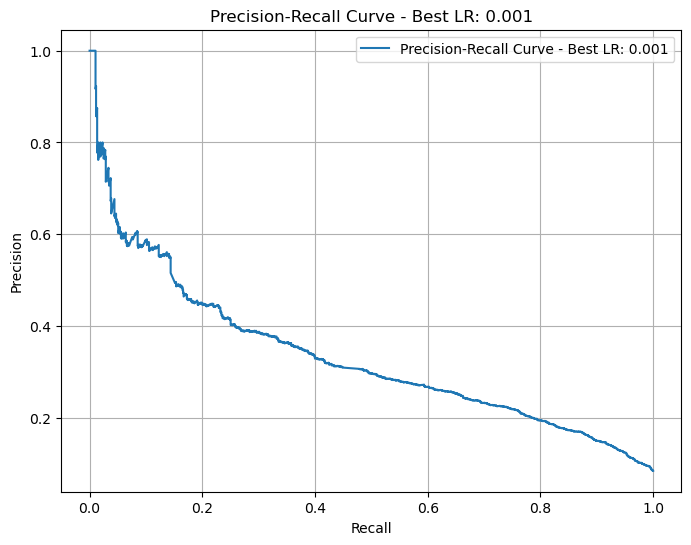

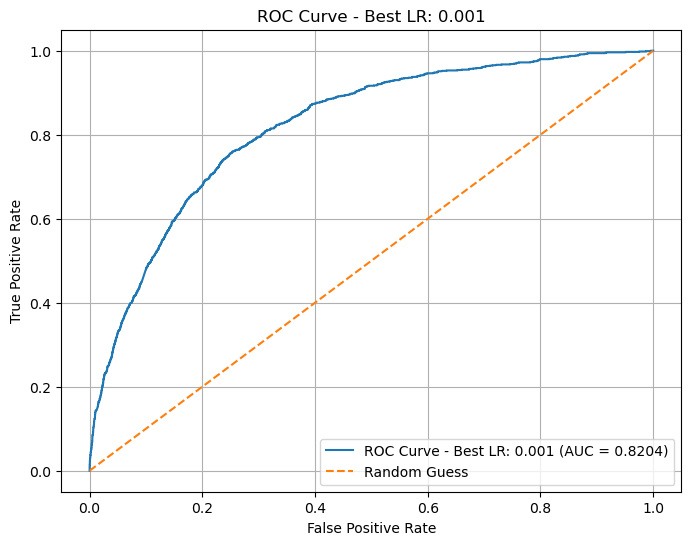

Test ROC AUC Score: 0.8204

=== Final Results ===
Best Learning Rate: 0.001
Test Loss: 0.3637
Test Accuracy: 0.7365
Test ROC AUC: 0.8204


In [71]:
# Run with multiple learning rates and test the best model
# # With SMOTE
# X_train_smote_tensor, Y_train_smote_tensor = to_tensor(X_train_smote, Y_train_smote)
# X_val_smote_tensor, Y_val_smote_tensor = to_tensor(X_val_smote, Y_val_smote)
learning_rates = [0.01,0.001]
modelX=NeuralNet(X_train_smote_tensor.shape[1])
best_lr, test_loss, test_accuracy, roc_auc, best_model = train_eval_find_best_lr_test(
    modelX,
    X_train_smote_tensor, Y_train_smote_tensor,
    X_val_smote_tensor, Y_val_smote_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search and Testing"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

In [9]:
# Step 5: Define the ToyModel and adjust it for the dataset
class ToyModel(nn.Module):
    def __init__(self, input_size):
        super(ToyModel, self).__init__()
        self.lin1 = nn.Linear(input_size, 3)  # Modified to accept the input_size of the dataset
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 1)  # Modified output to 1 for binary classification

        # Initialize weights and biases (Optional: to match ToyModel style, or you can let it randomly initialize)
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.zeros_(self.lin1.bias)
        nn.init.xavier_uniform_(self.lin2.weight)
        nn.init.zeros_(self.lin2.bias)

    def forward(self, input):
        return torch.sigmoid(self.lin2(self.relu(self.lin1(input))))

In [10]:
# Step 8: Interpret the ToyModel using Captum
def interpret_model(model, X_sample, description=""):
    """
    Uses Integrated Gradients from Captum to interpret the model.
    """
    model.eval()
    ig = IntegratedGradients(model)

    X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32).requires_grad_()
    baseline = torch.zeros_like(X_sample_tensor)  # Baseline of all zeros

    # Calculate attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_sample_tensor, baseline, target=0, return_convergence_delta=True)

    # Plot attributions
    plt.figure(figsize=(10, 6))
    plt.bar(range(X_sample_tensor.shape[1]), attributions.detach().numpy()[0], color='skyblue')
    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.title(f'Feature Attributions - {description}')
    plt.grid(True)
    plt.show()


=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 903.89batch/s, loss=0.338]  


Epoch 1/50: Train Loss = 0.2516, Val Loss = 0.2117, Val Accuracy = 0.9247


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 1019.01batch/s, loss=0.375] 


Epoch 2/50: Train Loss = 0.2126, Val Loss = 0.2092, Val Accuracy = 0.9254


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 1010.95batch/s, loss=0.375] 


Epoch 3/50: Train Loss = 0.2103, Val Loss = 0.2082, Val Accuracy = 0.9247


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 1038.86batch/s, loss=0.379] 


Epoch 4/50: Train Loss = 0.2093, Val Loss = 0.2072, Val Accuracy = 0.9246


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 1011.32batch/s, loss=0.372] 


Epoch 5/50: Train Loss = 0.2087, Val Loss = 0.2073, Val Accuracy = 0.9239


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 1012.19batch/s, loss=0.377] 


Epoch 6/50: Train Loss = 0.2083, Val Loss = 0.2071, Val Accuracy = 0.9239


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 1027.85batch/s, loss=0.382] 


Epoch 7/50: Train Loss = 0.2081, Val Loss = 0.2070, Val Accuracy = 0.9245


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 1050.87batch/s, loss=0.381] 


Epoch 8/50: Train Loss = 0.2077, Val Loss = 0.2070, Val Accuracy = 0.9245


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 968.48batch/s, loss=0.381]  


Epoch 9/50: Train Loss = 0.2076, Val Loss = 0.2069, Val Accuracy = 0.9235


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 957.19batch/s, loss=0.377]  


Epoch 10/50: Train Loss = 0.2075, Val Loss = 0.2067, Val Accuracy = 0.9242


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 980.70batch/s, loss=0.378]  


Epoch 11/50: Train Loss = 0.2072, Val Loss = 0.2068, Val Accuracy = 0.9237


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 1028.31batch/s, loss=0.377] 


Epoch 12/50: Train Loss = 0.2071, Val Loss = 0.2069, Val Accuracy = 0.9237


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 1006.35batch/s, loss=0.382] 


Epoch 13/50: Train Loss = 0.2071, Val Loss = 0.2070, Val Accuracy = 0.9241


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 1011.27batch/s, loss=0.378] 


Epoch 14/50: Train Loss = 0.2070, Val Loss = 0.2072, Val Accuracy = 0.9238


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 985.06batch/s, loss=0.383]  


Epoch 15/50: Train Loss = 0.2070, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 935.96batch/s, loss=0.383]  


Epoch 16/50: Train Loss = 0.2070, Val Loss = 0.2071, Val Accuracy = 0.9235


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 1016.29batch/s, loss=0.384] 


Epoch 17/50: Train Loss = 0.2069, Val Loss = 0.2071, Val Accuracy = 0.9245


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 952.87batch/s, loss=0.385]  


Epoch 18/50: Train Loss = 0.2068, Val Loss = 0.2071, Val Accuracy = 0.9243


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 1074.61batch/s, loss=0.386] 


Epoch 19/50: Train Loss = 0.2068, Val Loss = 0.2072, Val Accuracy = 0.9239


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 1011.93batch/s, loss=0.386] 


Epoch 20/50: Train Loss = 0.2067, Val Loss = 0.2072, Val Accuracy = 0.9241


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 1107.66batch/s, loss=0.383] 


Epoch 21/50: Train Loss = 0.2067, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 1078.61batch/s, loss=0.385] 


Epoch 22/50: Train Loss = 0.2067, Val Loss = 0.2071, Val Accuracy = 0.9242


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 1113.29batch/s, loss=0.382] 


Epoch 23/50: Train Loss = 0.2067, Val Loss = 0.2071, Val Accuracy = 0.9245


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 1082.27batch/s, loss=0.384] 


Epoch 24/50: Train Loss = 0.2067, Val Loss = 0.2071, Val Accuracy = 0.9241


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 1109.32batch/s, loss=0.386] 


Epoch 25/50: Train Loss = 0.2067, Val Loss = 0.2068, Val Accuracy = 0.9249


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 1079.78batch/s, loss=0.384] 


Epoch 26/50: Train Loss = 0.2066, Val Loss = 0.2071, Val Accuracy = 0.9239


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 1118.28batch/s, loss=0.385] 


Epoch 27/50: Train Loss = 0.2066, Val Loss = 0.2070, Val Accuracy = 0.9242


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 1111.11batch/s, loss=0.382] 


Epoch 28/50: Train Loss = 0.2066, Val Loss = 0.2071, Val Accuracy = 0.9237


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 1080.47batch/s, loss=0.385] 


Epoch 29/50: Train Loss = 0.2066, Val Loss = 0.2069, Val Accuracy = 0.9250


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 1122.01batch/s, loss=0.386] 


Epoch 30/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9243


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 1086.40batch/s, loss=0.385] 


Epoch 31/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9246


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 1121.87batch/s, loss=0.385] 


Epoch 32/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9243


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 1082.02batch/s, loss=0.382] 


Epoch 33/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9246


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 1111.64batch/s, loss=0.383] 


Epoch 34/50: Train Loss = 0.2064, Val Loss = 0.2071, Val Accuracy = 0.9250


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 1083.04batch/s, loss=0.384] 


Epoch 35/50: Train Loss = 0.2064, Val Loss = 0.2070, Val Accuracy = 0.9247


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 1118.53batch/s, loss=0.384] 


Epoch 36/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 1079.36batch/s, loss=0.384] 


Epoch 37/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9247


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 1125.36batch/s, loss=0.381] 


Epoch 38/50: Train Loss = 0.2064, Val Loss = 0.2073, Val Accuracy = 0.9247


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 965.06batch/s, loss=0.381]  


Epoch 39/50: Train Loss = 0.2064, Val Loss = 0.2073, Val Accuracy = 0.9246


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 1008.49batch/s, loss=0.385] 


Epoch 40/50: Train Loss = 0.2064, Val Loss = 0.2071, Val Accuracy = 0.9247


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 977.22batch/s, loss=0.383]  


Epoch 41/50: Train Loss = 0.2064, Val Loss = 0.2073, Val Accuracy = 0.9245


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 999.20batch/s, loss=0.385]  


Epoch 42/50: Train Loss = 0.2064, Val Loss = 0.2071, Val Accuracy = 0.9247


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 1000.69batch/s, loss=0.379] 


Epoch 43/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9246


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 963.24batch/s, loss=0.382]  


Epoch 44/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9249


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 985.55batch/s, loss=0.383]  


Epoch 45/50: Train Loss = 0.2063, Val Loss = 0.2071, Val Accuracy = 0.9246


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 974.89batch/s, loss=0.385]  


Epoch 46/50: Train Loss = 0.2063, Val Loss = 0.2071, Val Accuracy = 0.9245


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 970.49batch/s, loss=0.383]  


Epoch 47/50: Train Loss = 0.2063, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 1006.22batch/s, loss=0.381] 


Epoch 48/50: Train Loss = 0.2063, Val Loss = 0.2073, Val Accuracy = 0.9245


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 1008.11batch/s, loss=0.383] 


Epoch 49/50: Train Loss = 0.2063, Val Loss = 0.2072, Val Accuracy = 0.9247


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 1038.56batch/s, loss=0.384] 


Epoch 50/50: Train Loss = 0.2063, Val Loss = 0.2072, Val Accuracy = 0.9246
Best Validation Loss: 0.2067

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 1005.83batch/s, loss=0.385] 


Epoch 1/50: Train Loss = 0.2030, Val Loss = 0.2063, Val Accuracy = 0.9250


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 975.17batch/s, loss=0.385]  


Epoch 2/50: Train Loss = 0.2025, Val Loss = 0.2061, Val Accuracy = 0.9251


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 1011.24batch/s, loss=0.385] 


Epoch 3/50: Train Loss = 0.2023, Val Loss = 0.2059, Val Accuracy = 0.9251


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 1050.28batch/s, loss=0.385] 


Epoch 4/50: Train Loss = 0.2022, Val Loss = 0.2059, Val Accuracy = 0.9253


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 1014.50batch/s, loss=0.385] 


Epoch 5/50: Train Loss = 0.2022, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 1000.60batch/s, loss=0.384] 


Epoch 6/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 942.95batch/s, loss=0.384]  


Epoch 7/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9257


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 934.63batch/s, loss=0.384]  


Epoch 8/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 1071.64batch/s, loss=0.384] 


Epoch 9/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 1038.50batch/s, loss=0.384] 


Epoch 10/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 1106.75batch/s, loss=0.383] 


Epoch 11/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9258


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 1089.54batch/s, loss=0.383] 


Epoch 12/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9258


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 1126.69batch/s, loss=0.384] 


Epoch 13/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9259


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 1091.67batch/s, loss=0.383] 


Epoch 14/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9257


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 1131.52batch/s, loss=0.383] 


Epoch 15/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9257


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 1086.90batch/s, loss=0.384] 


Epoch 16/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 1084.18batch/s, loss=0.384] 


Epoch 17/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 1084.47batch/s, loss=0.384] 


Epoch 18/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 1129.02batch/s, loss=0.384] 


Epoch 19/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 1093.17batch/s, loss=0.384] 


Epoch 20/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 1127.72batch/s, loss=0.384] 


Epoch 21/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 1092.42batch/s, loss=0.383] 


Epoch 22/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 1129.14batch/s, loss=0.383] 


Epoch 23/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 1085.19batch/s, loss=0.383] 


Epoch 24/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 1125.33batch/s, loss=0.383] 


Epoch 25/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 1095.03batch/s, loss=0.383] 


Epoch 26/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 1125.47batch/s, loss=0.383] 


Epoch 27/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 1094.07batch/s, loss=0.383] 


Epoch 28/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 1135.40batch/s, loss=0.383] 


Epoch 29/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 1130.27batch/s, loss=0.383] 


Epoch 30/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 1093.23batch/s, loss=0.383] 


Epoch 31/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 1126.58batch/s, loss=0.383] 


Epoch 32/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9253


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 1094.17batch/s, loss=0.383] 


Epoch 33/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9253


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 1129.01batch/s, loss=0.383] 


Epoch 34/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 1091.63batch/s, loss=0.382] 


Epoch 35/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9254


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 1129.89batch/s, loss=0.383] 


Epoch 36/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9255


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 1101.94batch/s, loss=0.383] 


Epoch 37/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9255


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 1139.60batch/s, loss=0.383] 


Epoch 38/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 1100.73batch/s, loss=0.382] 


Epoch 39/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 1136.01batch/s, loss=0.383] 


Epoch 40/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 1094.49batch/s, loss=0.383] 


Epoch 41/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 1137.68batch/s, loss=0.382] 


Epoch 42/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 1096.54batch/s, loss=0.382] 


Epoch 43/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 1140.39batch/s, loss=0.382] 


Epoch 44/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 1103.77batch/s, loss=0.382] 


Epoch 45/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 1138.75batch/s, loss=0.382] 


Epoch 46/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 1139.24batch/s, loss=0.382] 


Epoch 47/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 1101.81batch/s, loss=0.382] 


Epoch 48/50: Train Loss = 0.2018, Val Loss = 0.2061, Val Accuracy = 0.9254


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 1085.63batch/s, loss=0.382] 


Epoch 49/50: Train Loss = 0.2018, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 1104.59batch/s, loss=0.382] 


Epoch 50/50: Train Loss = 0.2018, Val Loss = 0.2060, Val Accuracy = 0.9255
Best Validation Loss: 0.2059

=== Running with Learning Rate: 0.0001 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 1139.74batch/s, loss=0.384] 


Epoch 1/50: Train Loss = 0.2015, Val Loss = 0.2057, Val Accuracy = 0.9266


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 1104.77batch/s, loss=0.384] 


Epoch 2/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9266


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 1141.72batch/s, loss=0.384] 


Epoch 3/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9266


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 1086.97batch/s, loss=0.384] 


Epoch 4/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 1053.87batch/s, loss=0.384] 


Epoch 5/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9267


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 1101.40batch/s, loss=0.384] 


Epoch 6/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9267


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 1102.39batch/s, loss=0.384] 


Epoch 7/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 1084.52batch/s, loss=0.383] 


Epoch 8/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 1130.80batch/s, loss=0.383] 


Epoch 9/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 1097.71batch/s, loss=0.383] 


Epoch 10/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 1130.96batch/s, loss=0.383] 


Epoch 11/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 1130.14batch/s, loss=0.383] 


Epoch 12/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 1094.97batch/s, loss=0.383] 


Epoch 13/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 1121.11batch/s, loss=0.383] 


Epoch 14/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 1089.31batch/s, loss=0.383] 


Epoch 15/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 1130.48batch/s, loss=0.383] 


Epoch 16/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 1092.72batch/s, loss=0.383] 


Epoch 17/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 1126.22batch/s, loss=0.383] 


Epoch 18/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 1094.24batch/s, loss=0.383] 


Epoch 19/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9270


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 1136.85batch/s, loss=0.383] 


Epoch 20/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 1096.14batch/s, loss=0.383] 


Epoch 21/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 1136.22batch/s, loss=0.383] 


Epoch 22/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 1088.29batch/s, loss=0.383] 


Epoch 23/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 1127.57batch/s, loss=0.383] 


Epoch 24/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 1095.68batch/s, loss=0.383] 


Epoch 25/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 1132.22batch/s, loss=0.383] 


Epoch 26/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 1127.16batch/s, loss=0.383] 


Epoch 27/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 1091.91batch/s, loss=0.383] 


Epoch 28/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 1128.46batch/s, loss=0.383] 


Epoch 29/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 1093.85batch/s, loss=0.383] 


Epoch 30/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 1134.70batch/s, loss=0.383] 


Epoch 31/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 1089.07batch/s, loss=0.383] 


Epoch 32/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 1135.45batch/s, loss=0.383] 


Epoch 33/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 1093.44batch/s, loss=0.383] 


Epoch 34/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 1132.89batch/s, loss=0.383] 


Epoch 35/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 1096.03batch/s, loss=0.383] 


Epoch 36/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 1134.54batch/s, loss=0.383] 


Epoch 37/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 1101.48batch/s, loss=0.383] 


Epoch 38/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 1136.56batch/s, loss=0.383] 


Epoch 39/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 1088.99batch/s, loss=0.383] 


Epoch 40/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 1118.57batch/s, loss=0.383] 


Epoch 41/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 1091.13batch/s, loss=0.383] 


Epoch 42/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 1128.38batch/s, loss=0.383] 


Epoch 43/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 1131.40batch/s, loss=0.383] 


Epoch 44/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 1098.99batch/s, loss=0.382] 


Epoch 45/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 1138.36batch/s, loss=0.382] 


Epoch 46/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 1086.96batch/s, loss=0.382] 


Epoch 47/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 1129.08batch/s, loss=0.382] 


Epoch 48/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 1087.99batch/s, loss=0.382] 


Epoch 49/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 1133.34batch/s, loss=0.382] 


Epoch 50/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269
Best Validation Loss: 0.2057

=== Best Learning Rate: 0.0001 ===
Best Validation Loss: 0.2057

Best Threshold: 0.10, Best TPR: 0.7435

=== Testing Model: Best LR: 0.0001 ===
Test Loss: 0.2075, Test Accuracy: 0.7953

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     11480
         1.0       0.26      0.75      0.38      1054

    accuracy                           0.80     12534
   macro avg       0.61      0.77      0.63     12534
weighted avg       0.91      0.80      0.84     12534


Confusion Matrix:
[[9181 2299]
 [ 267  787]]


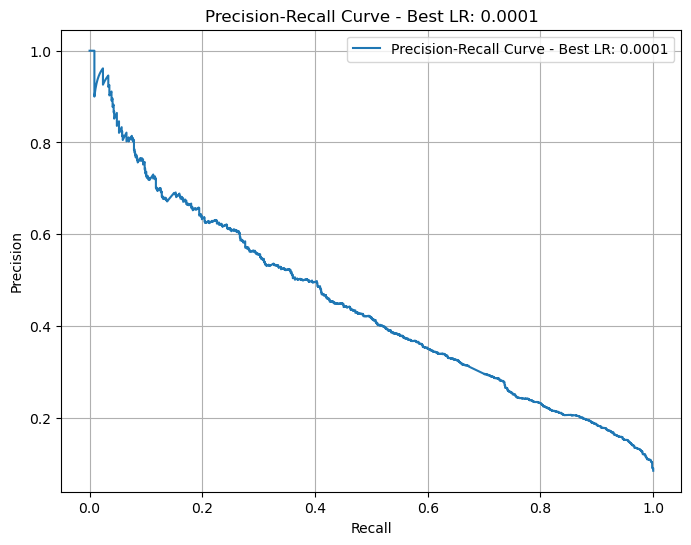

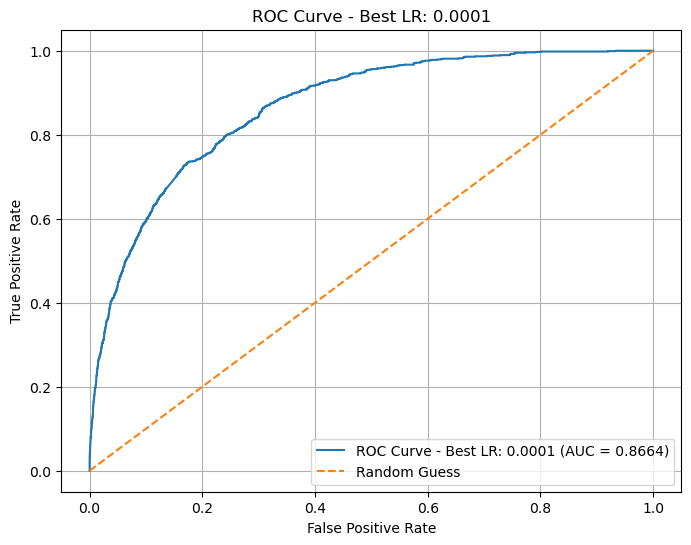

Test ROC AUC Score: 0.8664


ValueError: too many values to unpack (expected 3)

In [29]:
# Run with multiple learning rates and interpret the ToyModel
learning_rates = [0.01, 0.001, 0.0001]
modelTM = ToyModel(input_size=X_train_tensor.shape[1])
best_lr, best_model, best_threshold = train_eval_find_best_lr_test(
    modelTM,
    X_train_tensor, Y_train_tensor,
    X_val_tensor, Y_val_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search with ToyModel"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")

# Interpret the model using Captum
X_sample = X_test_tensor[:1]  # Take a sample from the test set for interpretation
interpret_model(best_model, X_sample, description="Final ToyModel Interpretation")